In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

<font size=8>**数据加载**</font>

In [2]:
# 加载原始数据
initial_data = np.load('initial_data/initial_data_rolling.npz')
X_cls_ini = initial_data['X_cls_ini']
y_cls_ini = initial_data['y_cls_ini']

# 加载标准化分类特征
processed_data = np.load('processed_data/processed_data_rolling.npz')
X_cls_sca = processed_data['X_cls_scaled']
y_cls_sca = processed_data['y_cls']

# 加载 LDA 特征
lda_data = np.load('features_rolling/lda_features.npz')
X_cls_lda = lda_data['X_lda']
y_cls_lda = lda_data['y_cls']

# 加载 Select 10 Best 分类特征
cls_select_data = np.load('features_rolling/select10best_classification_features.npz')
X_selected_cls = cls_select_data['X_selected_cls']
y_selected_cls = cls_select_data['y_cls']

# 加载 Select 50 Best 分类特征
cls_select_data = np.load('features_rolling/select50best_classification_features.npz')
X_selected_cls_50 = cls_select_data['X_selected_cls_50']
y_selected_cls_50 = cls_select_data['y_cls']

# 加载 Select 10 Best 清洗回归特征
reg_select_data = np.load('features_rolling/select10best_cleaned_classification_features.npz')
X_selected_cls_cleaned = reg_select_data['X_cls_cleaned']
y_selected_cls_cleaned = reg_select_data['y_cls']

<font size=8>**滚动预测训练函数以及评估指标**</font>

In [3]:
def rolling_evaluate_model_classification(model, X, y, n_splits=5, use_gridsearch=False, param_grid=None,
                                          scoring='accuracy', data_name='未命名分类集', n_jobs=-1):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {
        'accuracy': [], 'precision_macro': [], 'recall_macro': [], 'f1_macro': [],
        'precision_weighted': [], 'recall_weighted': [], 'f1_weighted': [],
        'auc': []
    }
    best_model = None
    best_score = float('-inf')

    print(f"\n===== 开始分类滚动评估：{data_name} ({n_splits}折)=====\n")
    n_classes = len(np.unique(y))

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if use_gridsearch and param_grid:
            search = GridSearchCV(model, param_grid=param_grid, scoring=scoring, cv=3, n_jobs=n_jobs)
            search.fit(X_train, y_train)
            fitted_model = search.best_estimator_
            model_info = search.best_params_
        else:
            fitted_model = model.fit(X_train, y_train)
            model_info = model.get_params()

        y_pred = fitted_model.predict(X_test)
        y_prob = None

        try:
            y_prob = fitted_model.predict_proba(X_test)
        except AttributeError:
            # 如果模型不支持 predict_proba（如 SVM），尝试 decision_function + sigmoid 转换
            try:
                decision = fitted_model.decision_function(X_test)
                y_prob = 1 / (1 + np.exp(-decision))  # Sigmoid
            except:
                y_prob = None

        y_test_bin = label_binarize(y_test, classes=np.unique(y)) if n_classes > 2 else y_test

        acc = accuracy_score(y_test, y_pred)
        pre_macro = precision_score(y_test, y_pred, average='macro')
        rec_macro = recall_score(y_test, y_pred, average='macro')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        pre_weighted = precision_score(y_test, y_pred, average='weighted')
        rec_weighted = recall_score(y_test, y_pred, average='weighted')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')

        if y_prob is not None and len(np.unique(y)) > 1:
            auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr', average='macro')
        else:
            auc = np.nan

        # 保存指标
        metrics['accuracy'].append(acc)
        metrics['precision_macro'].append(pre_macro)
        metrics['recall_macro'].append(rec_macro)
        metrics['f1_macro'].append(f1_macro)
        metrics['precision_weighted'].append(pre_weighted)
        metrics['recall_weighted'].append(rec_weighted)
        metrics['f1_weighted'].append(f1_weighted)
        metrics['auc'].append(auc)

        if acc > best_score:
            best_score = acc
            best_model = fitted_model
            best_fold_data = (X_test, y_test, y_pred, y_prob)
            best_metrics = {
                'accuracy': acc, 'f1_macro': f1_macro, 'auc': auc
            }
            best_params = model_info

        print(f"[Fold {fold}] ACC={acc:.4f}, F1={f1_macro:.4f}, AUC={auc:.4f}")

    # 平均指标
    avg_metrics = {k: np.nanmean(v) for k, v in metrics.items()}

    print(f"\n=== 平均指标 ({data_name}) ===")
    for k, v in avg_metrics.items():
        print(f"{k}: {v:.4f}")

    print("\n=== 最佳模型参数 ===")
    print(best_params)
    print("对应指标:", best_metrics)

    # 可视化最佳模型结果
    X_test, y_test, y_pred, y_prob = best_fold_data

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{data_name} - Confusion Matrix")
    plt.show()

    # ROC 曲线（多分类）
    if y_prob is not None and len(np.unique(y)) > 2:
        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'Class {i} ROC')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{data_name} - ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_model, metrics, avg_metrics, best_params


<font size=8>**模型**</font>

<font size=6>**KNN**</font>

In [4]:
model_knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

<font size=6>**Logistic 回归**</font>

In [5]:
model_logistic = LogisticRegression(solver='liblinear', random_state=42)
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

<font size=6>**LDA**</font>

In [6]:
model_lda = LinearDiscriminantAnalysis()
param_grid_lda = [
    {'solver': ['svd'], 'shrinkage': [None]},  # 仅 svd 无 shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto', 0.1, 0.2, 0.3]}  # 其它支持 shrinkage
]


<font size=6>**贝叶斯**</font>

In [7]:
model_nb = GaussianNB()
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

<font size=6>**SVM**</font>

In [8]:
model_svm = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

<font size=6>**随机森林**</font>

In [9]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=12)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

<font size=8>**模型训练结果**</font>

<font size=6>**KNN训练结果**</font>

<font size=5>**原始数据**</font>


===== 开始分类滚动评估：cls_data_ini (5折)=====

[Fold 1] ACC=0.6878, F1=0.3911, AUC=0.6854
[Fold 2] ACC=0.6810, F1=0.3289, AUC=0.6131
[Fold 3] ACC=0.7063, F1=0.3721, AUC=0.6814
[Fold 4] ACC=0.7095, F1=0.3478, AUC=0.6788
[Fold 5] ACC=0.7101, F1=0.3835, AUC=0.6945

=== 平均指标 (cls_data_ini) ===
accuracy: 0.6989
precision_macro: 0.4520
recall_macro: 0.3482
f1_macro: 0.3647
precision_weighted: 0.6527
recall_weighted: 0.6989
f1_weighted: 0.6646
auc: 0.6707

=== 最佳模型参数 ===
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
对应指标: {'accuracy': 0.7100572091866346, 'f1_macro': 0.38354150688804245, 'auc': np.float64(0.6945285275005257)}


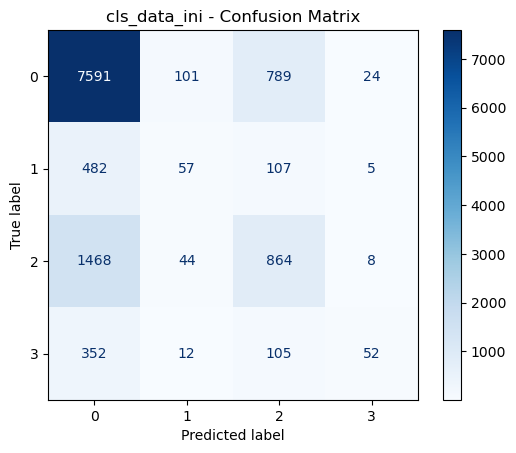

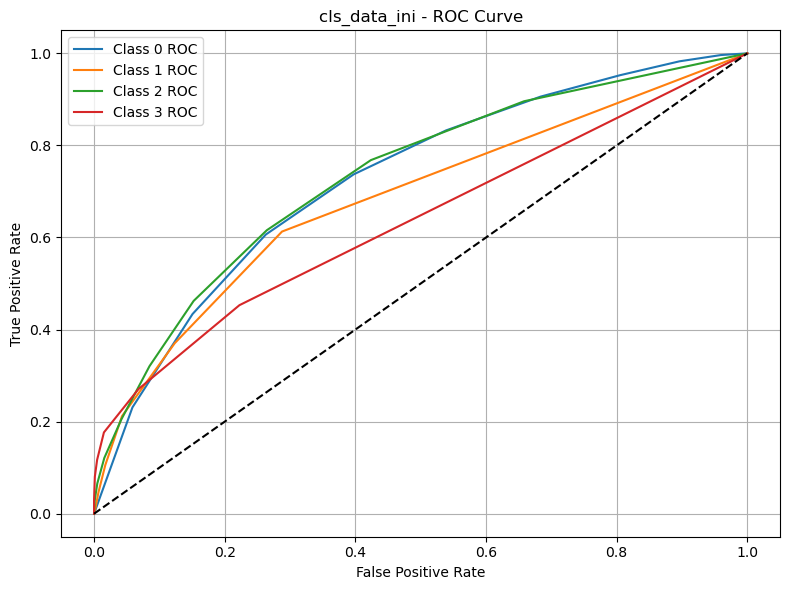

In [10]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_knn,
    X=X_cls_ini,
    y=y_cls_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_knn,
    data_name='cls_data_ini',
    n_jobs=-1
)

<font size=5>**标准化数据**</font>


===== 开始分类滚动评估：cls_data_sca (5折)=====

[Fold 1] ACC=0.8172, F1=0.5167, AUC=0.8180
[Fold 2] ACC=0.8164, F1=0.5259, AUC=0.8183
[Fold 3] ACC=0.8326, F1=0.5328, AUC=0.8359
[Fold 4] ACC=0.8355, F1=0.5186, AUC=0.8304
[Fold 5] ACC=0.8433, F1=0.5520, AUC=0.8459

=== 平均指标 (cls_data_sca) ===
accuracy: 0.8290
precision_macro: 0.6873
recall_macro: 0.5133
f1_macro: 0.5292
precision_weighted: 0.8149
recall_weighted: 0.8290
f1_weighted: 0.8086
auc: 0.8297

=== 最佳模型参数 ===
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
对应指标: {'accuracy': 0.8432965757399884, 'f1_macro': 0.5520496343358633, 'auc': np.float64(0.8458514592742523)}


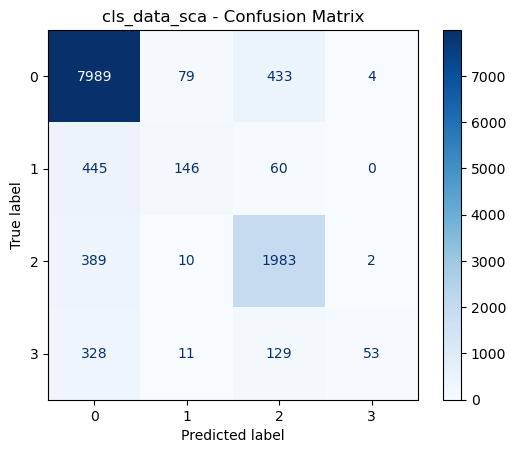

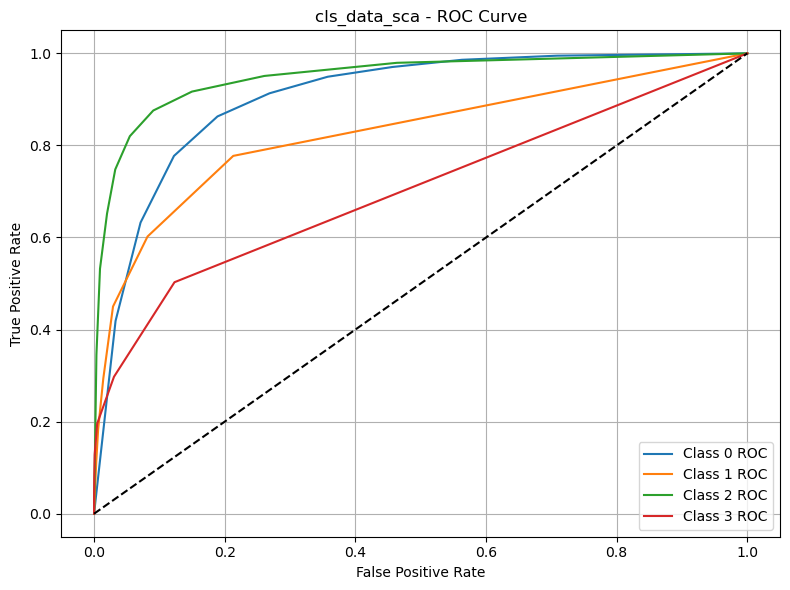

In [11]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_knn,
    X=X_cls_sca,
    y=y_cls_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_knn,
    data_name='cls_data_sca',
    n_jobs=-1
)

<font size=5>**LDA数据**</font>


===== 开始分类滚动评估：cls_data_lda (5折)=====

[Fold 1] ACC=0.8683, F1=0.6664, AUC=0.8880
[Fold 2] ACC=0.8675, F1=0.6561, AUC=0.8966
[Fold 3] ACC=0.8789, F1=0.6743, AUC=0.8940
[Fold 4] ACC=0.8788, F1=0.6713, AUC=0.8909
[Fold 5] ACC=0.8806, F1=0.7072, AUC=0.9074

=== 平均指标 (cls_data_lda) ===
accuracy: 0.8748
precision_macro: 0.7251
recall_macro: 0.6478
f1_macro: 0.6750
precision_weighted: 0.8659
recall_weighted: 0.8748
f1_weighted: 0.8683
auc: 0.8954

=== 最佳模型参数 ===
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
对应指标: {'accuracy': 0.8806069148495149, 'f1_macro': 0.7071719260468746, 'auc': np.float64(0.9074352517336179)}


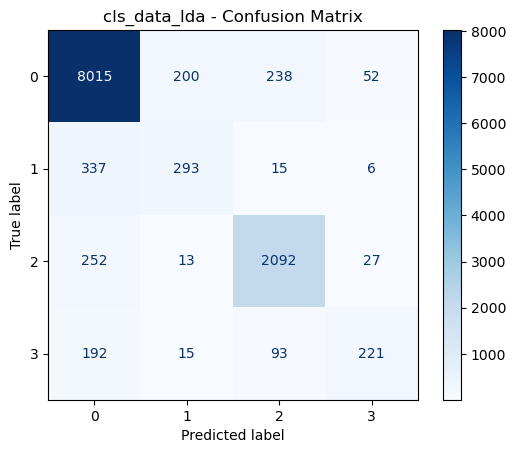

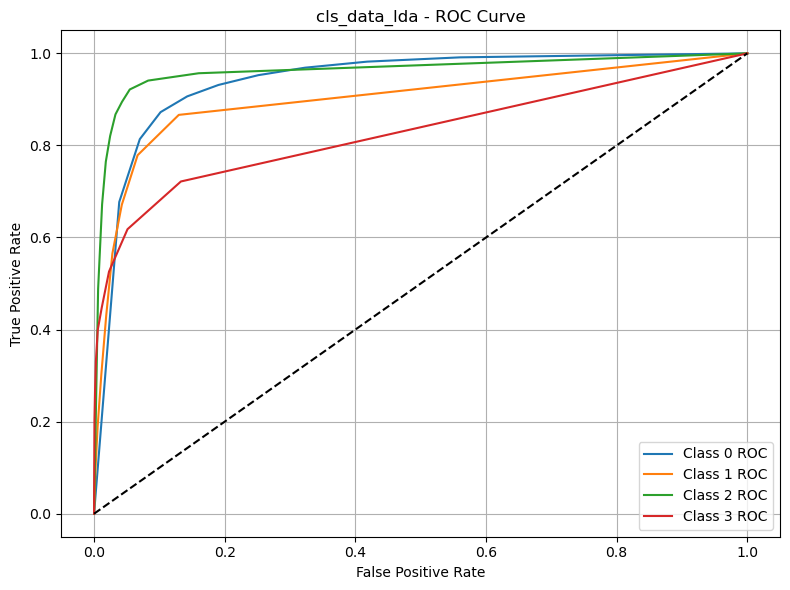

In [12]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_knn,
    X=X_cls_lda,
    y=y_cls_lda,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_knn,
    data_name='cls_data_lda',
    n_jobs=-1
)

<font size=5>**K=10最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect (5折)=====

[Fold 1] ACC=0.8214, F1=0.6216, AUC=0.8612
[Fold 2] ACC=0.8031, F1=0.5951, AUC=0.8396
[Fold 3] ACC=0.8086, F1=0.6019, AUC=0.8386
[Fold 4] ACC=0.8136, F1=0.5990, AUC=0.8346
[Fold 5] ACC=0.8111, F1=0.6191, AUC=0.8589

=== 平均指标 (cls_data_Kselect) ===
accuracy: 0.8116
precision_macro: 0.6130
recall_macro: 0.6181
f1_macro: 0.6073
precision_weighted: 0.8196
recall_weighted: 0.8116
f1_weighted: 0.8137
auc: 0.8466

=== 最佳模型参数 ===
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
对应指标: {'accuracy': 0.8214078434623995, 'f1_macro': 0.621570667714407, 'auc': np.float64(0.8612147697149235)}


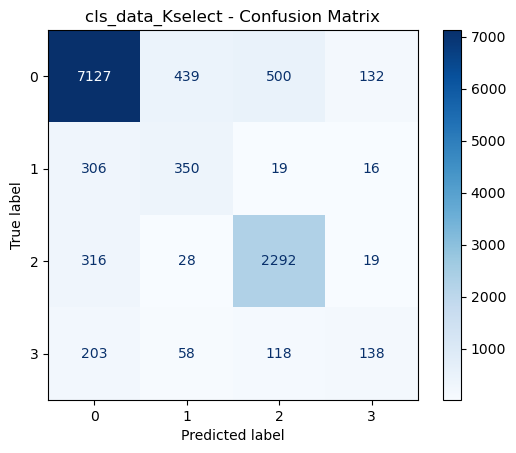

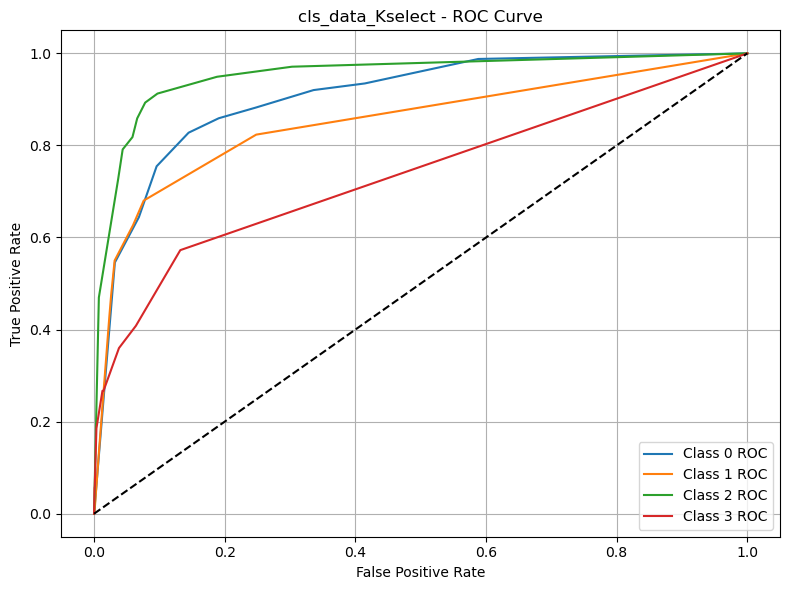

In [13]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_knn,
    X=X_selected_cls,
    y=y_selected_cls,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_knn,
    data_name='cls_data_Kselect',
    n_jobs=-1
)

<font size=5>**K=50最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_50 (5折)=====

[Fold 1] ACC=0.8727, F1=0.6656, AUC=0.8773
[Fold 2] ACC=0.8668, F1=0.6340, AUC=0.8714
[Fold 3] ACC=0.8787, F1=0.6616, AUC=0.8745
[Fold 4] ACC=0.8734, F1=0.6435, AUC=0.8737
[Fold 5] ACC=0.8782, F1=0.6853, AUC=0.8926

=== 平均指标 (cls_data_Kselect_50) ===
accuracy: 0.8740
precision_macro: 0.7401
recall_macro: 0.6211
f1_macro: 0.6580
precision_weighted: 0.8624
recall_weighted: 0.8740
f1_weighted: 0.8640
auc: 0.8779

=== 最佳模型参数 ===
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
对应指标: {'accuracy': 0.8786999419616948, 'f1_macro': 0.6616055235290549, 'auc': np.float64(0.8744866609940388)}


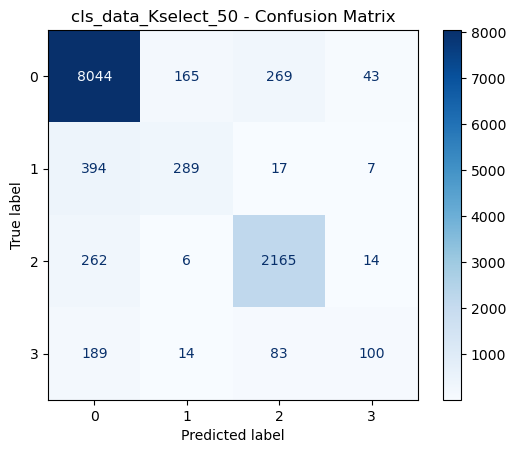

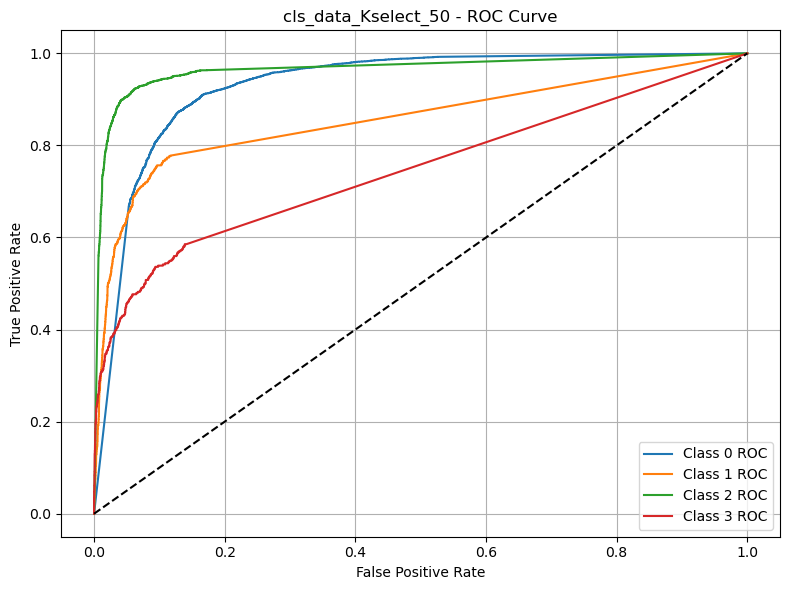

In [11]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_knn,
    X=X_selected_cls_50,
    y=y_selected_cls_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_knn,
    data_name='cls_data_Kselect_50',
    n_jobs=-1
)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_cleaned (5折)=====

[Fold 1] ACC=0.8574, F1=0.4835, AUC=0.8109
[Fold 2] ACC=0.8373, F1=0.4616, AUC=0.7809
[Fold 3] ACC=0.8458, F1=0.4812, AUC=0.8130
[Fold 4] ACC=0.8497, F1=0.4654, AUC=0.7802
[Fold 5] ACC=0.8510, F1=0.4690, AUC=0.8175

=== 平均指标 (cls_data_Kselect_cleaned) ===
accuracy: 0.8482
precision_macro: 0.4754
recall_macro: 0.4938
f1_macro: 0.4721
precision_weighted: 0.8500
recall_weighted: 0.8482
f1_weighted: 0.8478
auc: 0.8005

=== 最佳模型参数 ===
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
对应指标: {'accuracy': 0.8574152542372881, 'f1_macro': 0.4834681674394137, 'auc': np.float64(0.8109386774720275)}


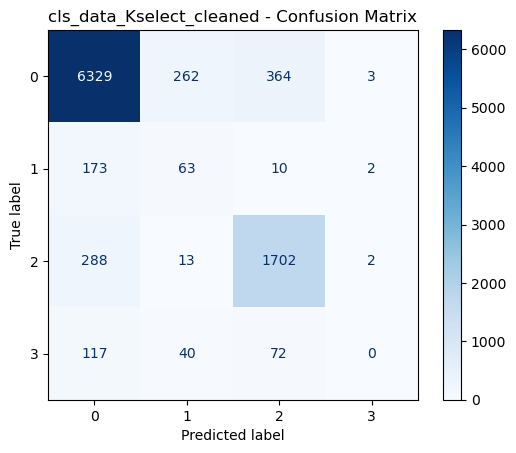

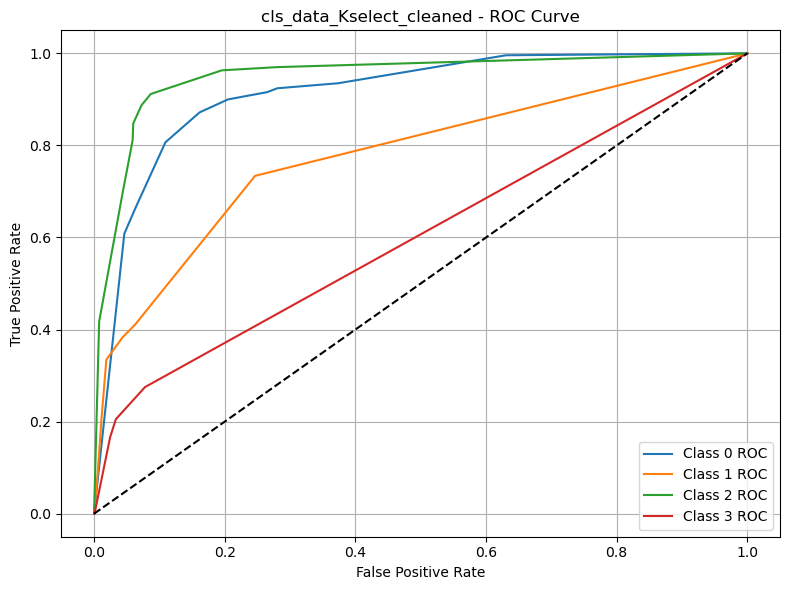

In [10]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_knn,
    X=X_selected_cls_cleaned,
    y=y_selected_cls_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_knn,
    data_name='cls_data_Kselect_cleaned',
    n_jobs=-1
)

<font size=6>**Logistic 回归训练结果**</font>

<font size=5>**原始数据**</font>


===== 开始分类滚动评估：cls_data_ini (5折)=====

[Fold 1] ACC=0.8768, F1=0.6584, AUC=0.9290
[Fold 2] ACC=0.8643, F1=0.6538, AUC=0.9208
[Fold 3] ACC=0.8882, F1=0.6915, AUC=0.9381
[Fold 4] ACC=0.8843, F1=0.6706, AUC=0.9322
[Fold 5] ACC=0.8879, F1=0.7079, AUC=0.9460

=== 平均指标 (cls_data_ini) ===
accuracy: 0.8803
precision_macro: 0.7750
recall_macro: 0.6353
f1_macro: 0.6764
precision_weighted: 0.8716
recall_weighted: 0.8803
f1_weighted: 0.8706
auc: 0.9332

=== 最佳模型参数 ===
{'C': 0.1, 'penalty': 'l1'}
对应指标: {'accuracy': 0.8881518945361081, 'f1_macro': 0.6915176905299952, 'auc': np.float64(0.9380735067809532)}


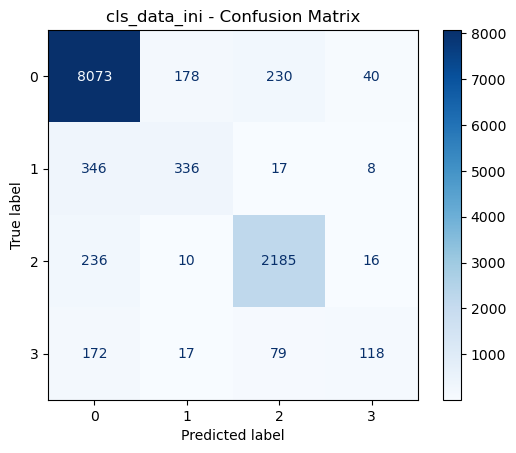

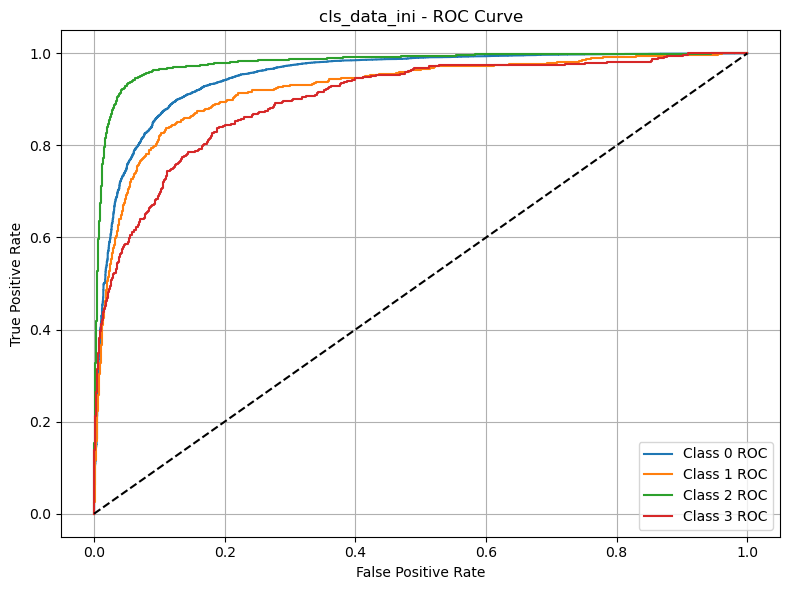

In [14]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_logistic,
    X=X_cls_ini,
    y=y_cls_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_logistic,
    data_name='cls_data_ini',
    n_jobs=-1
)

<font size=5>**标准化数据**</font>


===== 开始分类滚动评估：cls_data_sca (5折)=====

[Fold 1] ACC=0.8726, F1=0.6331, AUC=0.9239
[Fold 2] ACC=0.8664, F1=0.6631, AUC=0.9257
[Fold 3] ACC=0.8863, F1=0.6933, AUC=0.9368
[Fold 4] ACC=0.8829, F1=0.6723, AUC=0.9302
[Fold 5] ACC=0.8867, F1=0.7008, AUC=0.9449

=== 平均指标 (cls_data_sca) ===
accuracy: 0.8790
precision_macro: 0.7716
recall_macro: 0.6322
f1_macro: 0.6725
precision_weighted: 0.8704
recall_weighted: 0.8790
f1_weighted: 0.8691
auc: 0.9323

=== 最佳模型参数 ===
{'C': 0.01, 'penalty': 'l1'}
对应指标: {'accuracy': 0.8866594809717271, 'f1_macro': 0.7008488891453073, 'auc': np.float64(0.9448984785502567)}


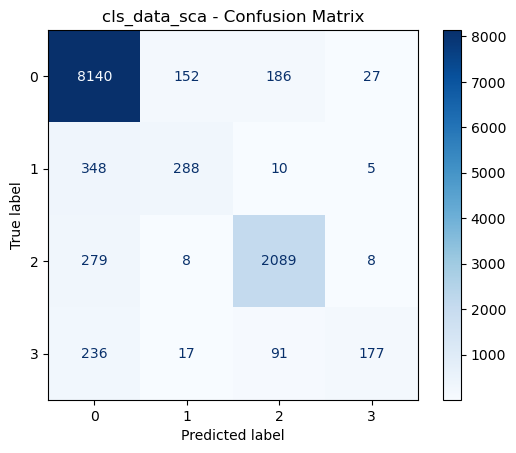

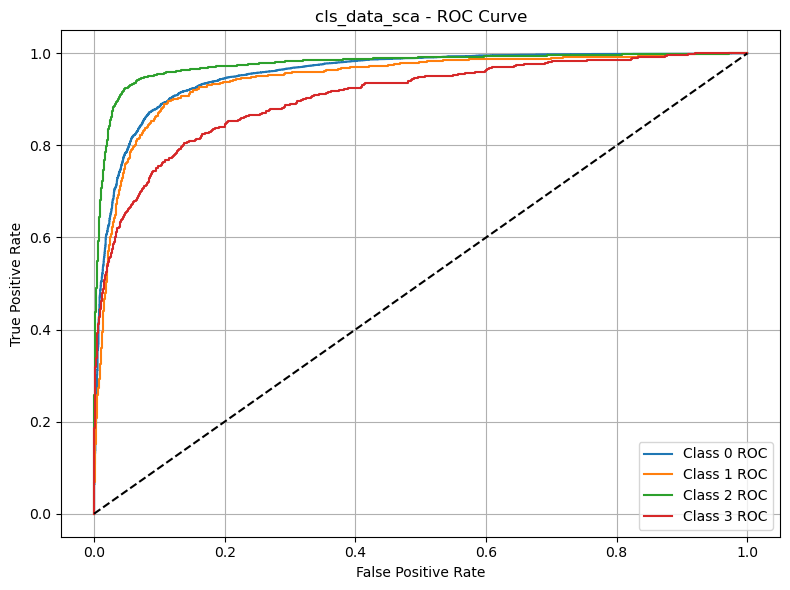

In [15]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_logistic,
    X=X_cls_sca,
    y=y_cls_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_logistic,
    data_name='cls_data_sca',
    n_jobs=-1
)

<font size=5>**LDA数据**</font>


===== 开始分类滚动评估：cls_data_lda (5折)=====

[Fold 1] ACC=0.8747, F1=0.6665, AUC=0.9435
[Fold 2] ACC=0.8828, F1=0.6743, AUC=0.9420
[Fold 3] ACC=0.8855, F1=0.6783, AUC=0.9431
[Fold 4] ACC=0.8789, F1=0.6664, AUC=0.9369
[Fold 5] ACC=0.8826, F1=0.7150, AUC=0.9473

=== 平均指标 (cls_data_lda) ===
accuracy: 0.8809
precision_macro: 0.7675
recall_macro: 0.6418
f1_macro: 0.6801
precision_weighted: 0.8721
recall_weighted: 0.8809
f1_weighted: 0.8721
auc: 0.9426

=== 最佳模型参数 ===
{'C': 0.01, 'penalty': 'l2'}
对应指标: {'accuracy': 0.8854987148660973, 'f1_macro': 0.6783256225923588, 'auc': np.float64(0.943143525010731)}


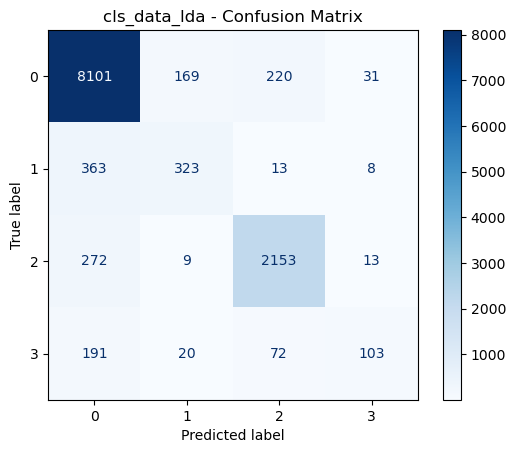

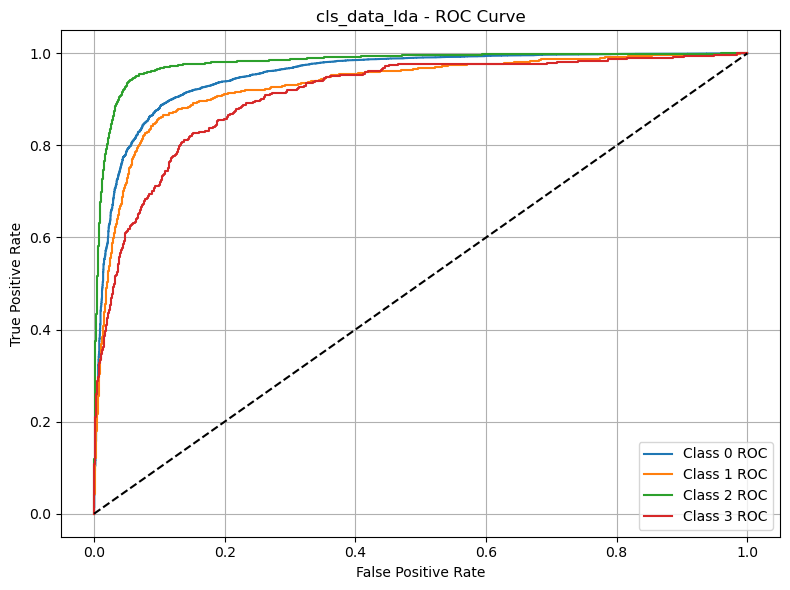

In [16]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_logistic,
    X=X_cls_lda,
    y=y_cls_lda,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_logistic,
    data_name='cls_data_lda',
    n_jobs=-1
)

<font size=5>**K=10最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect (5折)=====

[Fold 1] ACC=0.8561, F1=0.6292, AUC=0.9068
[Fold 2] ACC=0.8329, F1=0.5797, AUC=0.8892
[Fold 3] ACC=0.8542, F1=0.5972, AUC=0.9044
[Fold 4] ACC=0.8513, F1=0.5981, AUC=0.8971
[Fold 5] ACC=0.8483, F1=0.6023, AUC=0.9117

=== 平均指标 (cls_data_Kselect) ===
accuracy: 0.8486
precision_macro: 0.7309
recall_macro: 0.5551
f1_macro: 0.6013
precision_weighted: 0.8370
recall_weighted: 0.8486
f1_weighted: 0.8327
auc: 0.9018

=== 最佳模型参数 ===
{'C': 10, 'penalty': 'l1'}
对应指标: {'accuracy': 0.8560650029019152, 'f1_macro': 0.6291866788020892, 'auc': np.float64(0.9067959879054092)}


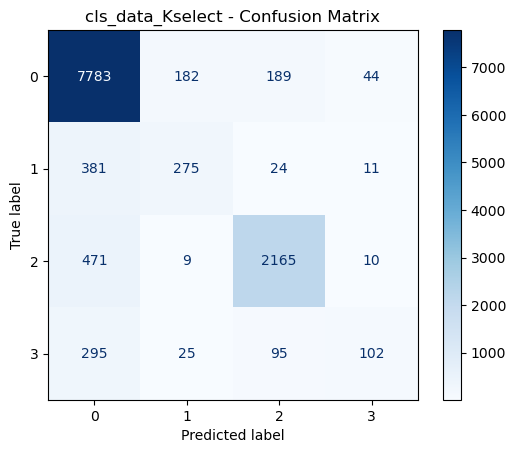

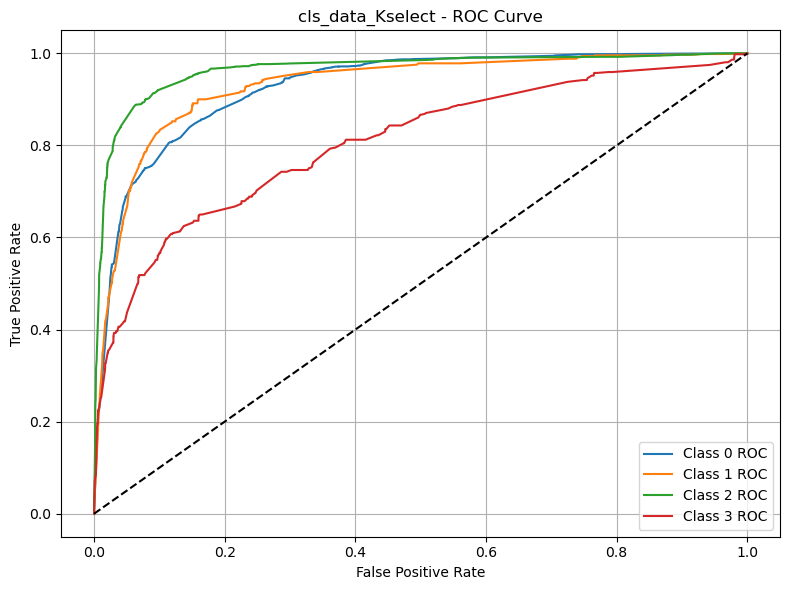

In [17]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_logistic,
    X=X_selected_cls,
    y=y_selected_cls,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_logistic,
    data_name='cls_data_Kselect',
    n_jobs=-1
)

<font size=5>**K=50最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_50 (5折)=====

[Fold 1] ACC=0.8782, F1=0.6704, AUC=0.9273
[Fold 2] ACC=0.8808, F1=0.6638, AUC=0.9230
[Fold 3] ACC=0.8859, F1=0.6642, AUC=0.9277
[Fold 4] ACC=0.8805, F1=0.6634, AUC=0.9202
[Fold 5] ACC=0.8808, F1=0.6880, AUC=0.9363

=== 平均指标 (cls_data_Kselect_50) ===
accuracy: 0.8812
precision_macro: 0.7658
recall_macro: 0.6315
f1_macro: 0.6700
precision_weighted: 0.8715
recall_weighted: 0.8812
f1_weighted: 0.8713
auc: 0.9269

=== 最佳模型参数 ===
{'C': 10, 'penalty': 'l1'}
对应指标: {'accuracy': 0.8859132741895365, 'f1_macro': 0.6642374873537263, 'auc': np.float64(0.9277440507153012)}


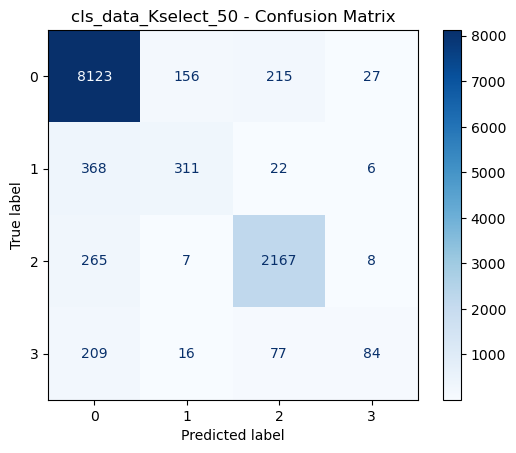

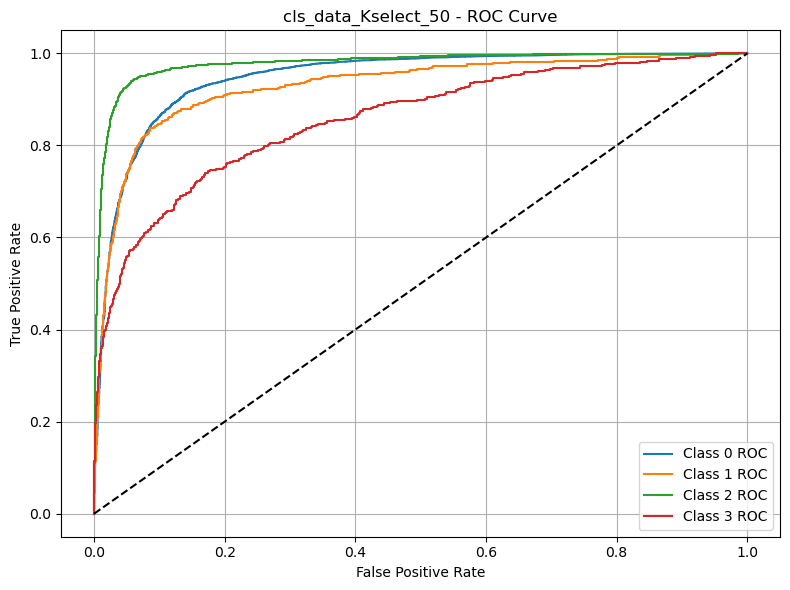

In [12]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_logistic,
    X=X_selected_cls_50,
    y=y_selected_cls_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_logistic,
    data_name='cls_data_Kselect_50',
    n_jobs=-1
)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_cleaned (5折)=====



d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 1] ACC=0.8841, F1=0.4783, AUC=0.8747


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 2] ACC=0.8672, F1=0.4212, AUC=0.8452


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 3] ACC=0.8880, F1=0.4393, AUC=0.8627


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 4] ACC=0.8840, F1=0.4283, AUC=0.8538
[Fold 5] ACC=0.8868, F1=0.4289, AUC=0.8779

=== 平均指标 (cls_data_Kselect_cleaned) ===
accuracy: 0.8820
precision_macro: 0.5310
recall_macro: 0.4272
f1_macro: 0.4392
precision_weighted: 0.8511
recall_weighted: 0.8820
f1_weighted: 0.8587
auc: 0.8628

=== 最佳模型参数 ===
{'C': 0.01, 'penalty': 'l2'}
对应指标: {'accuracy': 0.8880296610169491, 'f1_macro': 0.43933215615288457, 'auc': np.float64(0.8626967311153697)}


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


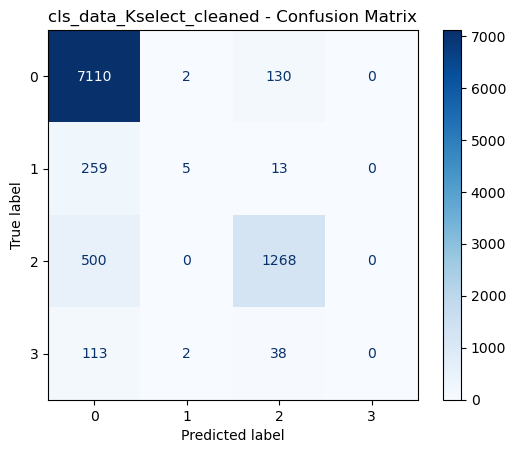

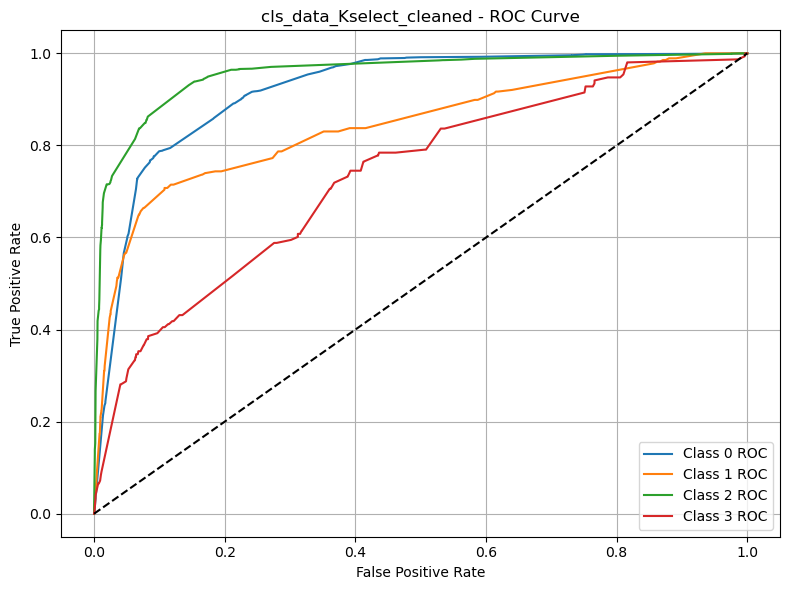

In [11]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_logistic,
    X=X_selected_cls_cleaned,
    y=y_selected_cls_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_logistic,
    data_name='cls_data_Kselect_cleaned',
    n_jobs=-1
)

<font size=6>**LDA训练结果**</font>

<font size=5>**原始数据**</font>


===== 开始分类滚动评估：cls_data_ini (5折)=====

[Fold 1] ACC=0.8647, F1=0.7042, AUC=0.9244
[Fold 2] ACC=0.8362, F1=0.6667, AUC=0.9193
[Fold 3] ACC=0.8489, F1=0.6733, AUC=0.9198
[Fold 4] ACC=0.8726, F1=0.6977, AUC=0.9216
[Fold 5] ACC=0.8759, F1=0.7320, AUC=0.9368

=== 平均指标 (cls_data_ini) ===
accuracy: 0.8596
precision_macro: 0.6873
recall_macro: 0.7091
f1_macro: 0.6948
precision_weighted: 0.8674
recall_weighted: 0.8596
f1_weighted: 0.8624
auc: 0.9244

=== 最佳模型参数 ===
{'shrinkage': 'auto', 'solver': 'lsqr'}
对应指标: {'accuracy': 0.8758809385623083, 'f1_macro': 0.7319938467839398, 'auc': np.float64(0.936773955180876)}


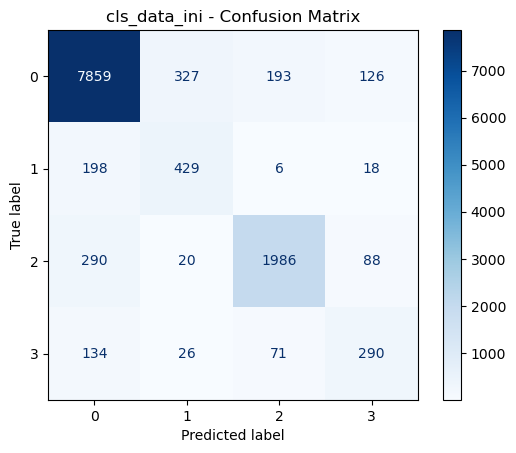

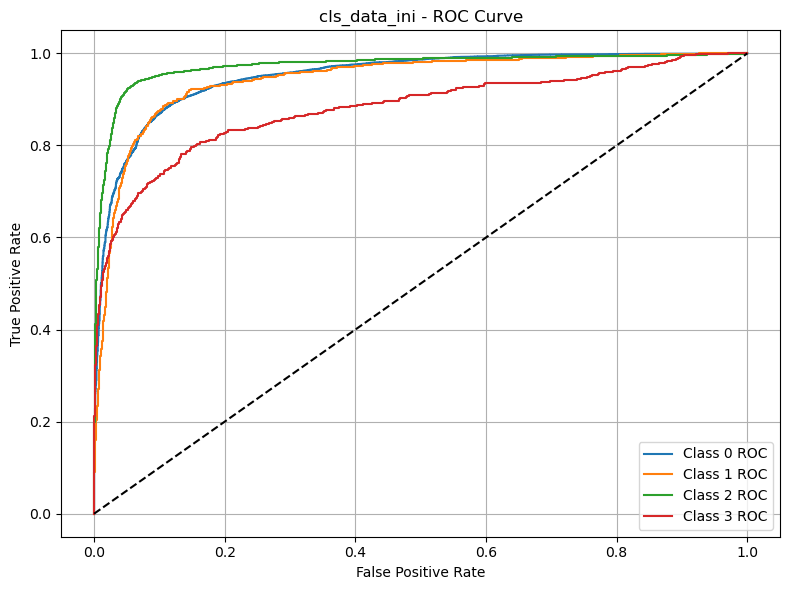

In [22]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_lda,
    X=X_cls_ini,
    y=y_cls_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lda,
    data_name='cls_data_ini',
    n_jobs=-1
)

<font size=5>**标准化数据**</font>


===== 开始分类滚动评估：cls_data_csa (5折)=====

[Fold 1] ACC=0.8673, F1=0.7030, AUC=0.9267
[Fold 2] ACC=0.8509, F1=0.6817, AUC=0.9268
[Fold 3] ACC=0.8684, F1=0.6949, AUC=0.9274
[Fold 4] ACC=0.8759, F1=0.6983, AUC=0.9278
[Fold 5] ACC=0.8774, F1=0.7312, AUC=0.9415

=== 平均指标 (cls_data_csa) ===
accuracy: 0.8680
precision_macro: 0.6958
recall_macro: 0.7126
f1_macro: 0.7018
precision_weighted: 0.8735
recall_weighted: 0.8680
f1_weighted: 0.8700
auc: 0.9300

=== 最佳模型参数 ===
{'shrinkage': 0.3, 'solver': 'lsqr'}
对应指标: {'accuracy': 0.8773733521266893, 'f1_macro': 0.731179629413611, 'auc': np.float64(0.9415263935324171)}


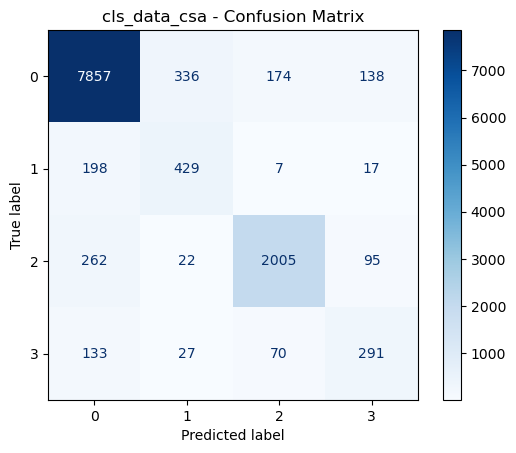

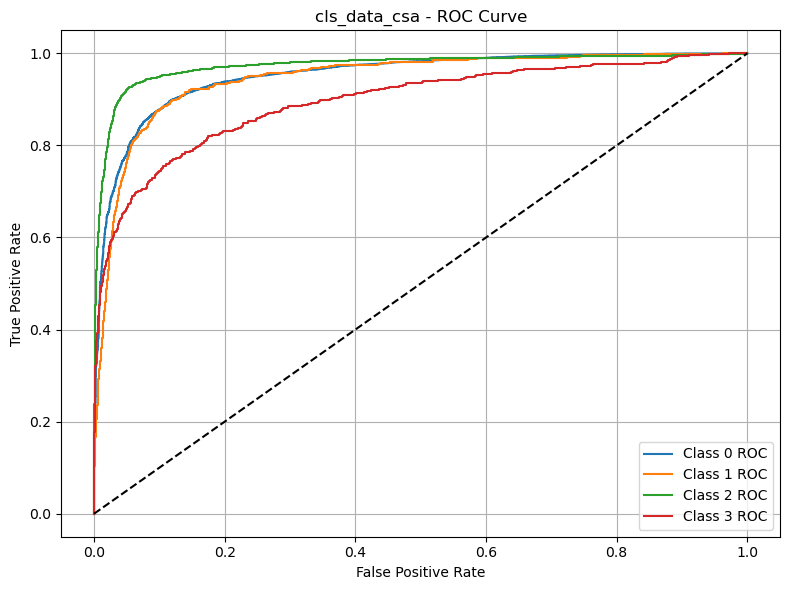

In [23]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_lda,
    X=X_cls_sca,
    y=y_cls_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lda,
    data_name='cls_data_csa',
    n_jobs=-1
)

<font size=5>**LDA数据**</font>


===== 开始分类滚动评估：cls_data_lda (5折)=====

[Fold 1] ACC=0.8652, F1=0.7078, AUC=0.9321
[Fold 2] ACC=0.8673, F1=0.7044, AUC=0.9350
[Fold 3] ACC=0.8731, F1=0.7024, AUC=0.9299
[Fold 4] ACC=0.8733, F1=0.7009, AUC=0.9283
[Fold 5] ACC=0.8743, F1=0.7303, AUC=0.9382

=== 平均指标 (cls_data_lda) ===
accuracy: 0.8706
precision_macro: 0.7039
recall_macro: 0.7178
f1_macro: 0.7091
precision_weighted: 0.8745
recall_weighted: 0.8706
f1_weighted: 0.8721
auc: 0.9327

=== 最佳模型参数 ===
{'shrinkage': 0.1, 'solver': 'lsqr'}
对应指标: {'accuracy': 0.8743056131332394, 'f1_macro': 0.7303112724282348, 'auc': np.float64(0.9381606606981148)}


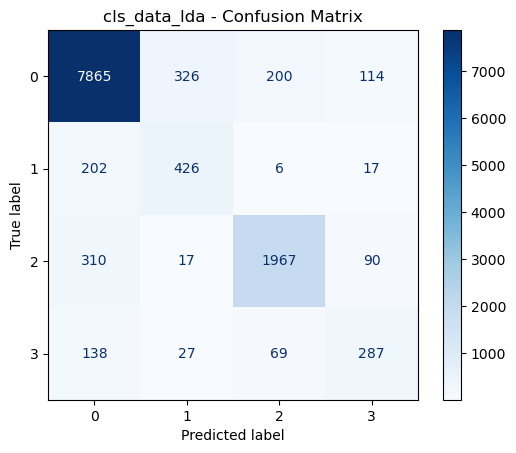

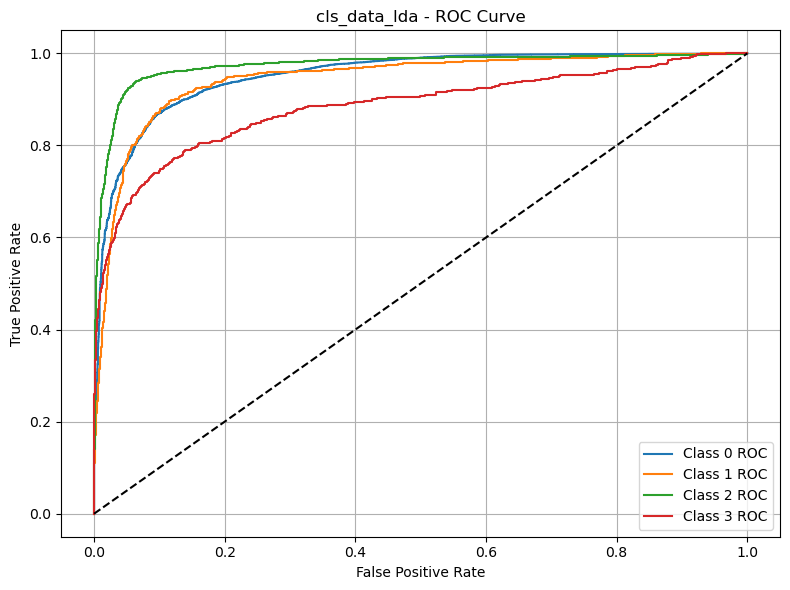

In [24]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_lda,
    X=X_cls_lda,
    y=y_cls_lda,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lda,
    data_name='cls_data_lda',
    n_jobs=-1
)

<font size=5>**K=10最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect (5折)=====

[Fold 1] ACC=0.8270, F1=0.6571, AUC=0.8962
[Fold 2] ACC=0.8023, F1=0.6196, AUC=0.8785
[Fold 3] ACC=0.8221, F1=0.6286, AUC=0.8886
[Fold 4] ACC=0.8266, F1=0.6361, AUC=0.8862
[Fold 5] ACC=0.8265, F1=0.6539, AUC=0.8984

=== 平均指标 (cls_data_Kselect) ===
accuracy: 0.8209
precision_macro: 0.6414
recall_macro: 0.6516
f1_macro: 0.6391
precision_weighted: 0.8345
recall_weighted: 0.8209
f1_weighted: 0.8240
auc: 0.8896

=== 最佳模型参数 ===
{'shrinkage': 0.2, 'solver': 'lsqr'}
对应指标: {'accuracy': 0.8269629383964845, 'f1_macro': 0.6571049032551539, 'auc': np.float64(0.8961789391517345)}


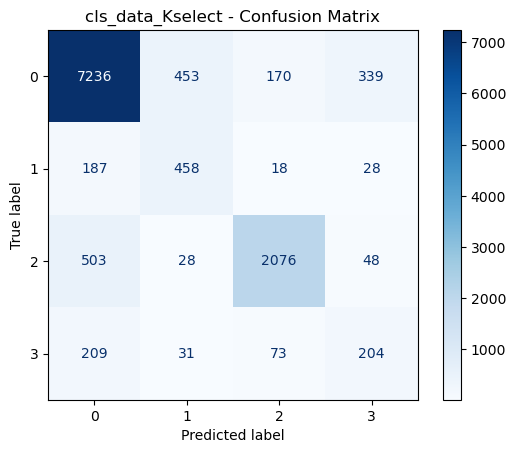

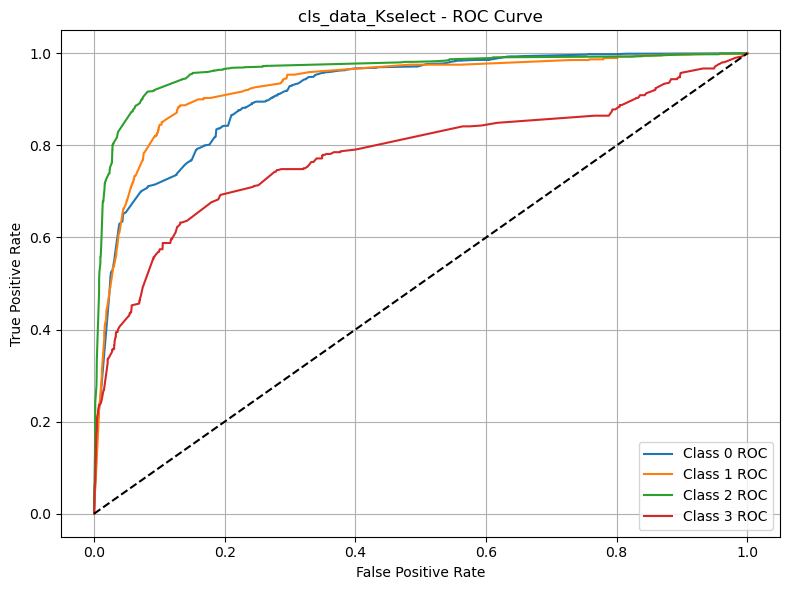

In [25]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_lda,
    X=X_selected_cls,
    y=y_selected_cls,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lda,
    data_name='cls_data_Kselect',
    n_jobs=-1
)

<font size=5>**K=50最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_50 (5折)=====

[Fold 1] ACC=0.8569, F1=0.6967, AUC=0.9194
[Fold 2] ACC=0.8397, F1=0.6680, AUC=0.9158
[Fold 3] ACC=0.8611, F1=0.6798, AUC=0.9171
[Fold 4] ACC=0.8602, F1=0.6791, AUC=0.9104
[Fold 5] ACC=0.8644, F1=0.7092, AUC=0.9281

=== 平均指标 (cls_data_Kselect_50) ===
accuracy: 0.8565
precision_macro: 0.6745
recall_macro: 0.7065
f1_macro: 0.6866
precision_weighted: 0.8666
recall_weighted: 0.8565
f1_weighted: 0.8604
auc: 0.9182

=== 最佳模型参数 ===
{'shrinkage': 0.3, 'solver': 'lsqr'}
对应指标: {'accuracy': 0.8644391012353868, 'f1_macro': 0.7092443487278359, 'auc': np.float64(0.9280701248098072)}


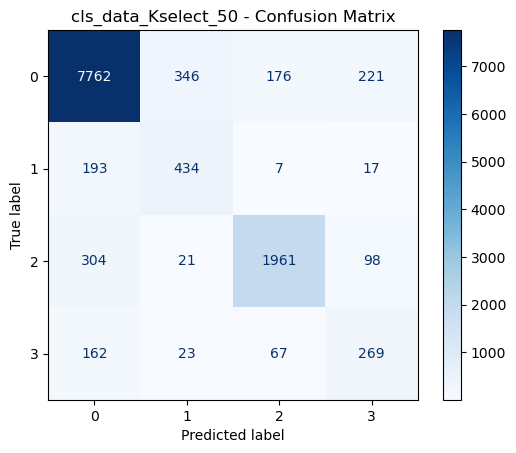

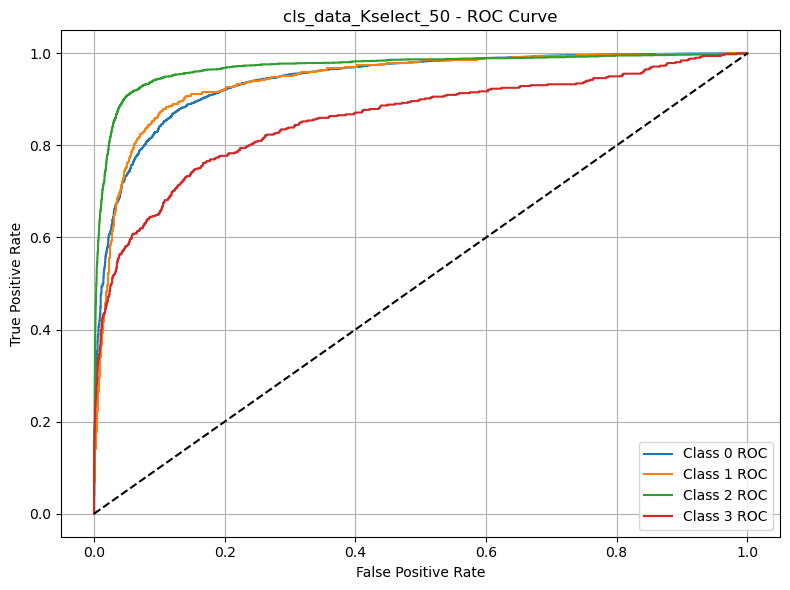

In [26]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_lda,
    X=X_selected_cls_50,
    y=y_selected_cls_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lda,
    data_name='cls_data_Kselect_50',
    n_jobs=-1
)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_cleaned (5折)=====

[Fold 1] ACC=0.8664, F1=0.5303, AUC=0.8588
[Fold 2] ACC=0.8140, F1=0.4825, AUC=0.8298
[Fold 3] ACC=0.8442, F1=0.5201, AUC=0.8513
[Fold 4] ACC=0.8354, F1=0.5021, AUC=0.8350
[Fold 5] ACC=0.8304, F1=0.4954, AUC=0.8576

=== 平均指标 (cls_data_Kselect_cleaned) ===
accuracy: 0.8381
precision_macro: 0.5515
recall_macro: 0.5573
f1_macro: 0.5061
precision_weighted: 0.8615
recall_weighted: 0.8381
f1_weighted: 0.8429
auc: 0.8465

=== 最佳模型参数 ===
{'shrinkage': 'auto', 'solver': 'lsqr'}
对应指标: {'accuracy': 0.8664194915254237, 'f1_macro': 0.5302821452807936, 'auc': np.float64(0.8588036219799928)}


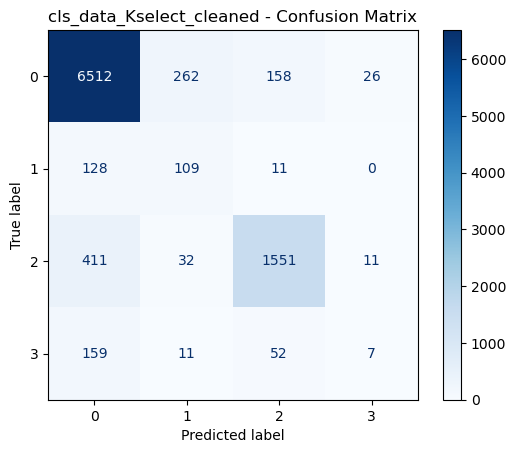

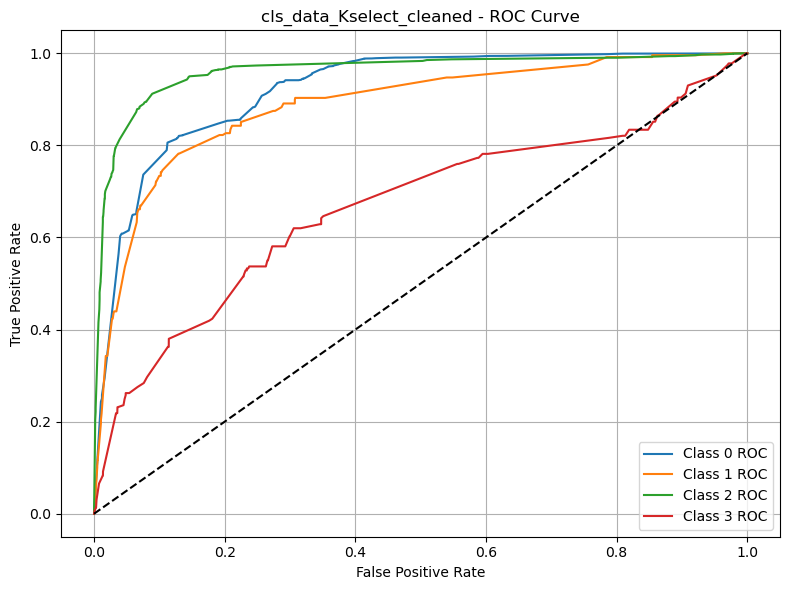

In [12]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_lda,
    X=X_selected_cls_cleaned,
    y=y_selected_cls_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lda,
    data_name='cls_data_Kselect_cleaned',
    n_jobs=-1
)

<font size=6>**贝叶斯训练结果**</font>

<font size=5>**原始数据**</font>


===== 开始分类滚动评估：cls_data_ini (5折)=====

[Fold 1] ACC=0.6895, F1=0.3455, AUC=0.7159
[Fold 2] ACC=0.6762, F1=0.3287, AUC=0.6909
[Fold 3] ACC=0.2141, F1=0.1118, AUC=0.5589
[Fold 4] ACC=0.2171, F1=0.1156, AUC=0.5701
[Fold 5] ACC=0.2177, F1=0.1217, AUC=0.5768

=== 平均指标 (cls_data_ini) ===
accuracy: 0.4029
precision_macro: 0.3816
recall_macro: 0.2861
f1_macro: 0.2047
precision_weighted: 0.5619
recall_weighted: 0.4029
f1_weighted: 0.3191
auc: 0.6225

=== 最佳模型参数 ===
{'var_smoothing': 1e-09}
对应指标: {'accuracy': 0.689495066744051, 'f1_macro': 0.3455290522775214, 'auc': np.float64(0.715898046790455)}


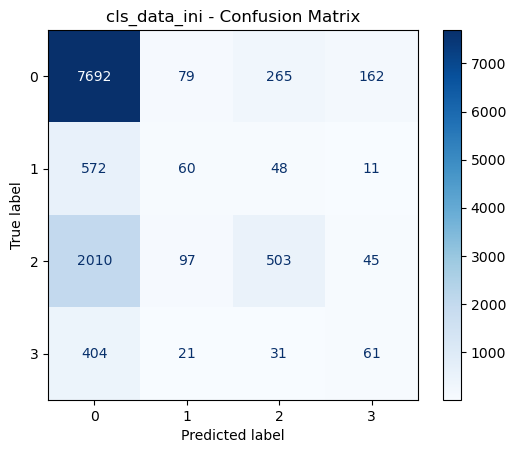

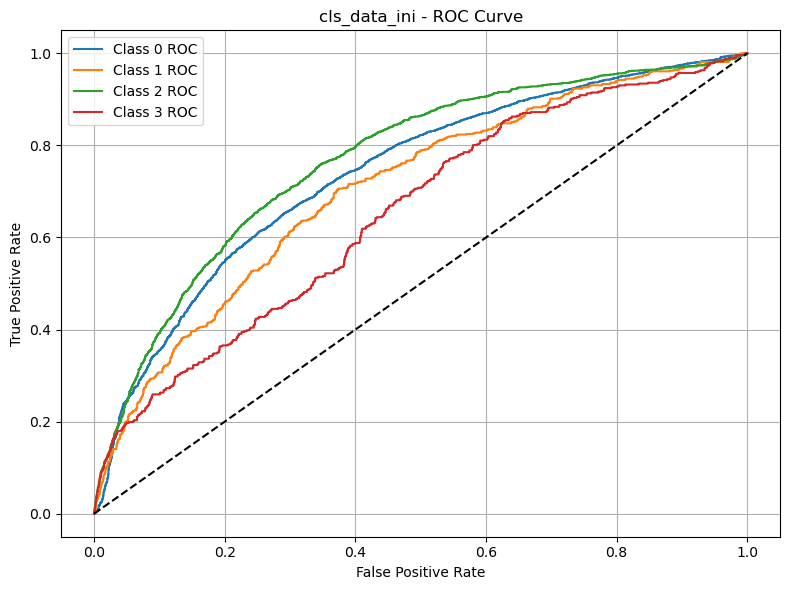

In [22]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_nb,
    X=X_cls_ini,
    y=y_cls_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_nb,
    data_name='cls_data_ini',
    n_jobs=-1
)

<font size=5>**标准化数据**</font>


===== 开始分类滚动评估：cls_data_sca (5折)=====

[Fold 1] ACC=0.0898, F1=0.1257, AUC=0.7477
[Fold 2] ACC=0.0937, F1=0.1037, AUC=0.7224
[Fold 3] ACC=0.0704, F1=0.0697, AUC=0.7182
[Fold 4] ACC=0.0740, F1=0.0669, AUC=0.7468
[Fold 5] ACC=0.0745, F1=0.0735, AUC=0.7555

=== 平均指标 (cls_data_sca) ===
accuracy: 0.0805
precision_macro: 0.3416
recall_macro: 0.3662
f1_macro: 0.0879
precision_weighted: 0.5981
recall_weighted: 0.0805
f1_weighted: 0.0357
auc: 0.7381

=== 最佳模型参数 ===
{'var_smoothing': 1e-07}
对应指标: {'accuracy': 0.09369040709725562, 'f1_macro': 0.10372633888467106, 'auc': np.float64(0.7223590419532322)}


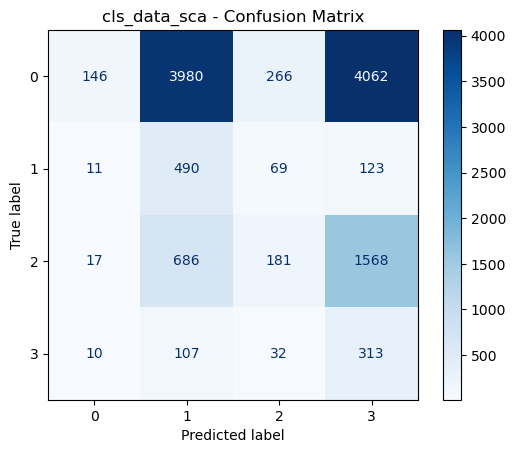

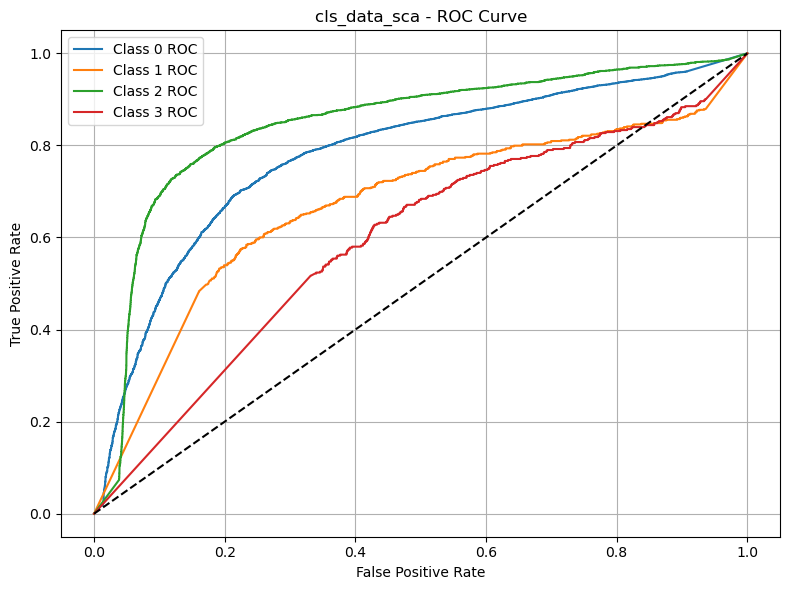

In [23]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_nb,
    X=X_cls_sca,
    y=y_cls_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_nb,
    data_name='cls_data_sca',
    n_jobs=-1
)

<font size=5>**LDA数据**</font>


===== 开始分类滚动评估：cls_data_lda (5折)=====

[Fold 1] ACC=0.8691, F1=0.7079, AUC=0.9271
[Fold 2] ACC=0.8683, F1=0.6990, AUC=0.9335
[Fold 3] ACC=0.8730, F1=0.6933, AUC=0.9273
[Fold 4] ACC=0.8726, F1=0.6973, AUC=0.9280
[Fold 5] ACC=0.8766, F1=0.7266, AUC=0.9385

=== 平均指标 (cls_data_lda) ===
accuracy: 0.8719
precision_macro: 0.6982
recall_macro: 0.7134
f1_macro: 0.7048
precision_weighted: 0.8753
recall_weighted: 0.8719
f1_weighted: 0.8734
auc: 0.9309

=== 最佳模型参数 ===
{'var_smoothing': 1e-09}
对应指标: {'accuracy': 0.8766271453444988, 'f1_macro': 0.7266119700051163, 'auc': np.float64(0.9384853438074636)}


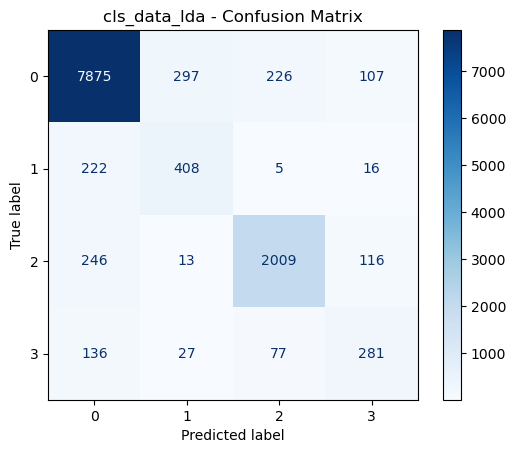

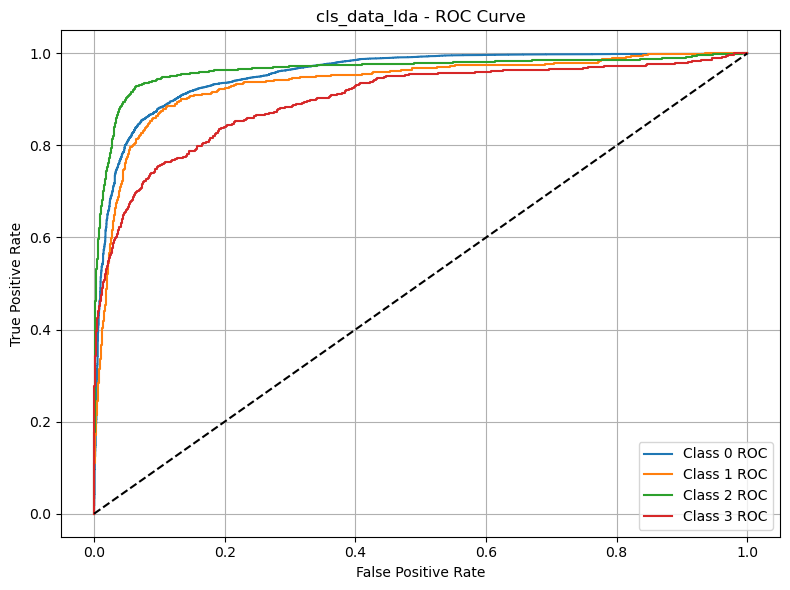

In [24]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_nb,
    X=X_cls_lda,
    y=y_cls_lda,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_nb,
    data_name='cls_data_lda',
    n_jobs=-1
)

<font size=5>**K=10最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect (5折)=====

[Fold 1] ACC=0.7979, F1=0.6282, AUC=0.8938
[Fold 2] ACC=0.7863, F1=0.6118, AUC=0.8822
[Fold 3] ACC=0.7937, F1=0.6200, AUC=0.8896
[Fold 4] ACC=0.8040, F1=0.6239, AUC=0.8861
[Fold 5] ACC=0.7976, F1=0.6373, AUC=0.8965

=== 平均指标 (cls_data_Kselect) ===
accuracy: 0.7959
precision_macro: 0.5889
recall_macro: 0.6948
f1_macro: 0.6242
precision_weighted: 0.8357
recall_weighted: 0.7959
f1_weighted: 0.8092
auc: 0.8896

=== 最佳模型参数 ===
{'var_smoothing': 1e-09}
对应指标: {'accuracy': 0.8039963518779537, 'f1_macro': 0.6238812067927545, 'auc': np.float64(0.8861228324335421)}


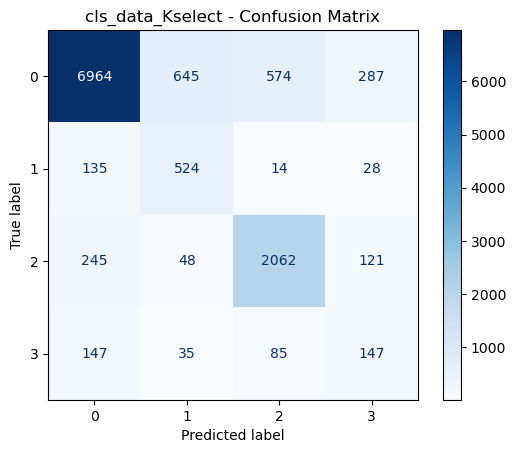

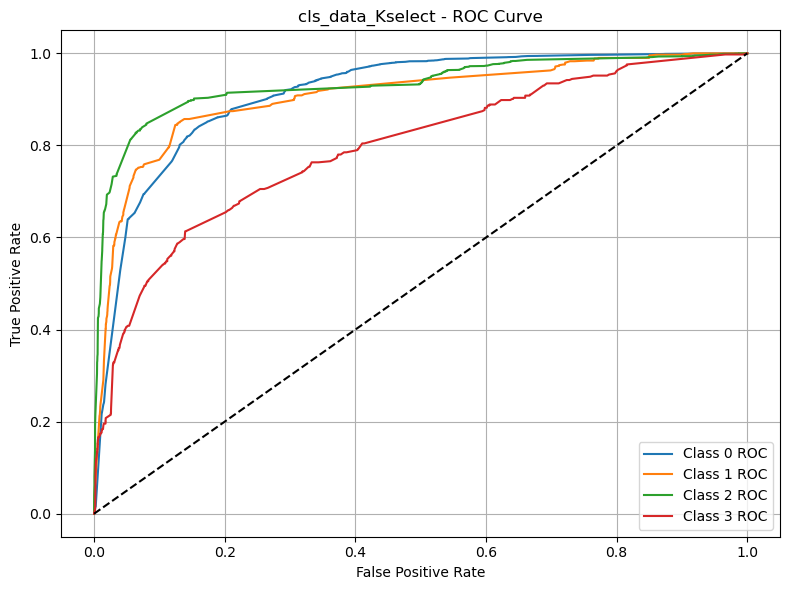

In [25]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_nb,
    X=X_selected_cls,
    y=y_selected_cls,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_nb,
    data_name='cls_data_Kselect',
    n_jobs=-1
)

<font size=5>**K=50最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_50 (5折)=====

[Fold 1] ACC=0.7918, F1=0.6215, AUC=0.9037
[Fold 2] ACC=0.7936, F1=0.6223, AUC=0.9077
[Fold 3] ACC=0.8019, F1=0.6250, AUC=0.9035
[Fold 4] ACC=0.7988, F1=0.6212, AUC=0.9016
[Fold 5] ACC=0.7931, F1=0.6344, AUC=0.9164

=== 平均指标 (cls_data_Kselect_50) ===
accuracy: 0.7959
precision_macro: 0.5936
recall_macro: 0.7258
f1_macro: 0.6249
precision_weighted: 0.8703
recall_weighted: 0.7959
f1_weighted: 0.8216
auc: 0.9066

=== 最佳模型参数 ===
{'var_smoothing': 1e-09}
对应指标: {'accuracy': 0.8019235552607579, 'f1_macro': 0.6249904226866904, 'auc': np.float64(0.9035344621940429)}


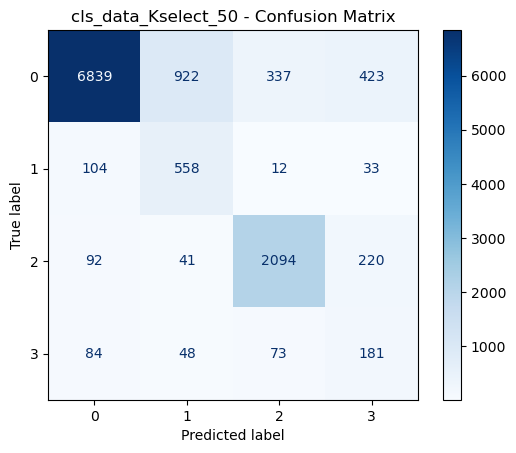

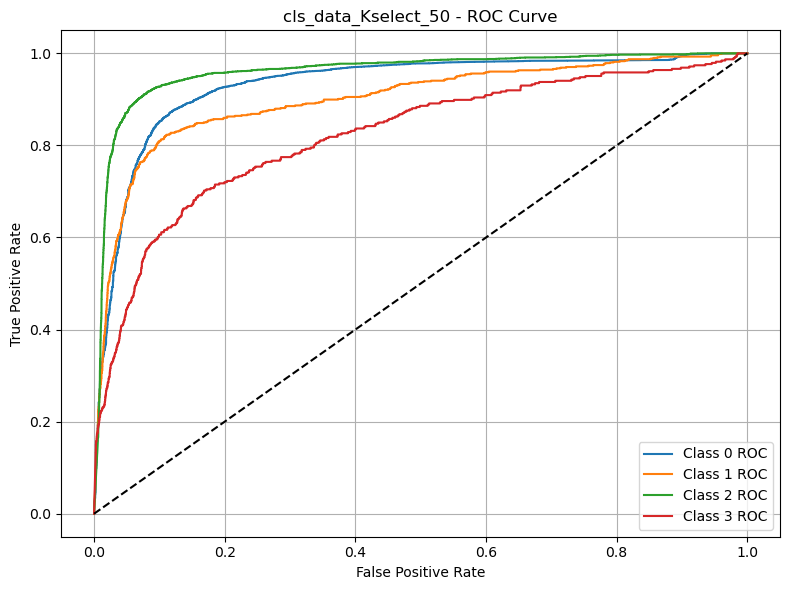

In [14]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_nb,
    X=X_selected_cls_50,
    y=y_selected_cls_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_nb,
    data_name='cls_data_Kselect_50',
    n_jobs=-1
)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_cleaned (5折)=====

[Fold 1] ACC=0.8262, F1=0.5021, AUC=0.8618
[Fold 2] ACC=0.8179, F1=0.4968, AUC=0.8449
[Fold 3] ACC=0.8270, F1=0.5049, AUC=0.8648
[Fold 4] ACC=0.8340, F1=0.4945, AUC=0.8487
[Fold 5] ACC=0.8260, F1=0.4943, AUC=0.8700

=== 平均指标 (cls_data_Kselect_cleaned) ===
accuracy: 0.8262
precision_macro: 0.4799
recall_macro: 0.5649
f1_macro: 0.4985
precision_weighted: 0.8582
recall_weighted: 0.8262
f1_weighted: 0.8380
auc: 0.8580

=== 最佳模型参数 ===
{'var_smoothing': 1e-09}
对应指标: {'accuracy': 0.8340042372881356, 'f1_macro': 0.4944822842032981, 'auc': np.float64(0.8486926332162955)}


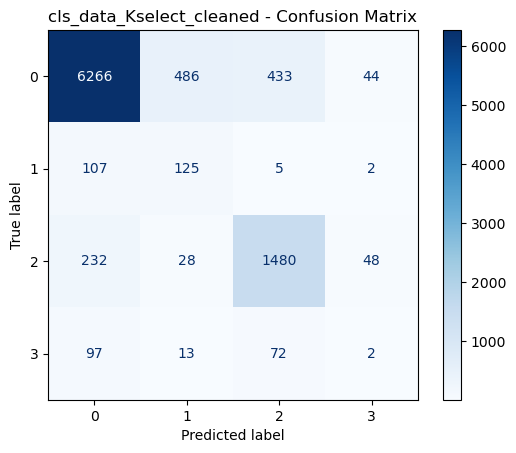

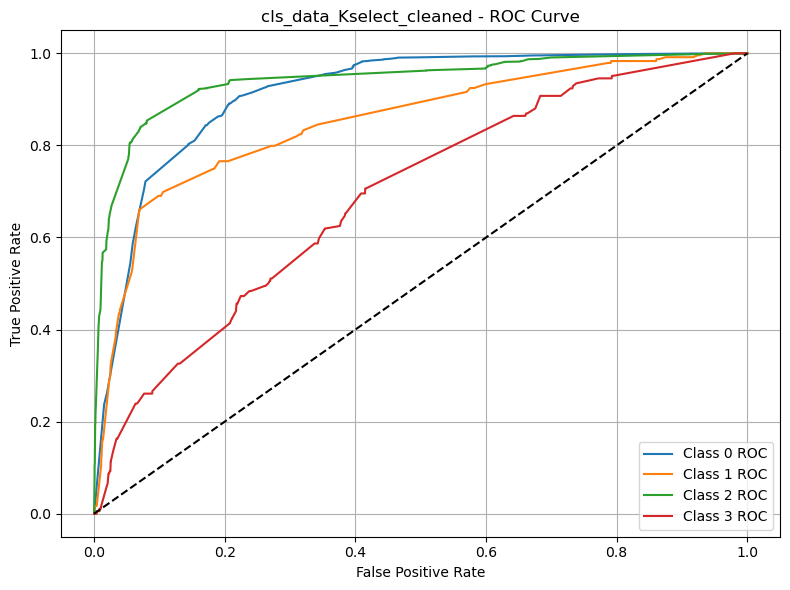

In [13]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_nb,
    X=X_selected_cls_cleaned,
    y=y_selected_cls_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_nb,
    data_name='cls_data_Kselect_cleaned',
    n_jobs=-1
)

<font size=6>**随机森林训练结果**</font>

<font size=5>**原始数据**</font>

<font size=5>**标准化数据**</font>

<font size=5>**LDA数据**</font>


===== 开始分类滚动评估：cls_data_lda (5折)=====

[Fold 1] ACC=0.8742, F1=0.6722, AUC=0.9278
[Fold 2] ACC=0.8827, F1=0.6751, AUC=0.9439
[Fold 3] ACC=0.8879, F1=0.6852, AUC=0.9446
[Fold 4] ACC=0.8849, F1=0.6817, AUC=0.9399
[Fold 5] ACC=0.8891, F1=0.7265, AUC=0.9524

=== 平均指标 (cls_data_lda) ===
accuracy: 0.8838
precision_macro: 0.7588
recall_macro: 0.6535
f1_macro: 0.6881
precision_weighted: 0.8746
recall_weighted: 0.8838
f1_weighted: 0.8760
auc: 0.9417

=== 最佳模型参数 ===
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
对应指标: {'accuracy': 0.8891468369123622, 'f1_macro': 0.7265197331016877, 'auc': np.float64(0.9524244685283029)}


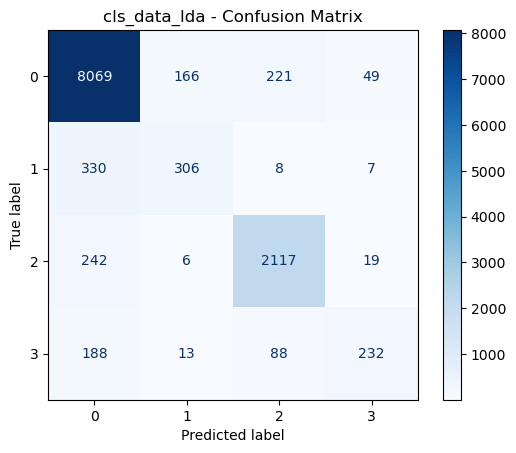

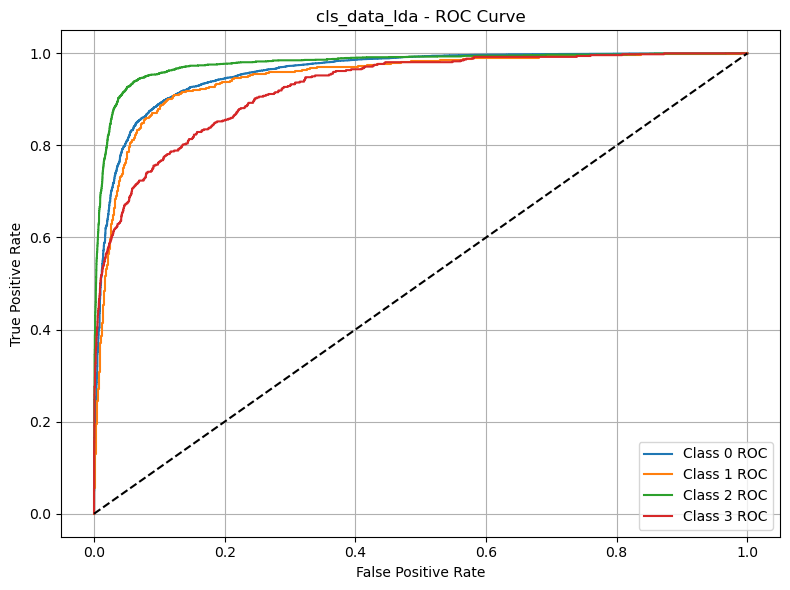

In [26]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_rf,
    X=X_cls_lda,
    y=y_cls_lda,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='cls_data_lda',
    n_jobs=-1
)

<font size=5>**K=10最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect (5折)=====

[Fold 1] ACC=0.8532, F1=0.6219, AUC=0.8986
[Fold 2] ACC=0.8344, F1=0.6091, AUC=0.8881
[Fold 3] ACC=0.8580, F1=0.6360, AUC=0.9064
[Fold 4] ACC=0.8521, F1=0.6207, AUC=0.8976
[Fold 5] ACC=0.8527, F1=0.6444, AUC=0.9133

=== 平均指标 (cls_data_Kselect) ===
accuracy: 0.8501
precision_macro: 0.7217
recall_macro: 0.5814
f1_macro: 0.6264
precision_weighted: 0.8390
recall_weighted: 0.8501
f1_weighted: 0.8379
auc: 0.9008

=== 最佳模型参数 ===
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
对应指标: {'accuracy': 0.8579719757897355, 'f1_macro': 0.6360171364913887, 'auc': np.float64(0.9064404783584096)}


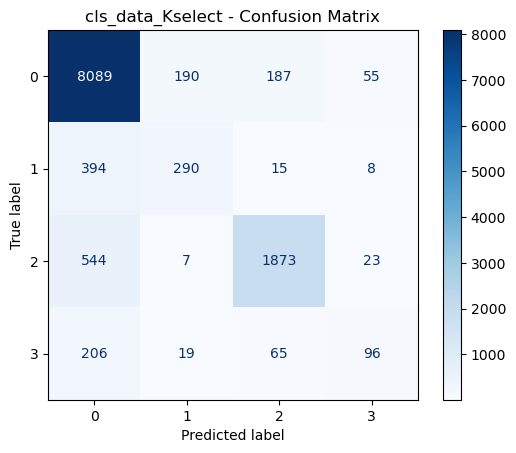

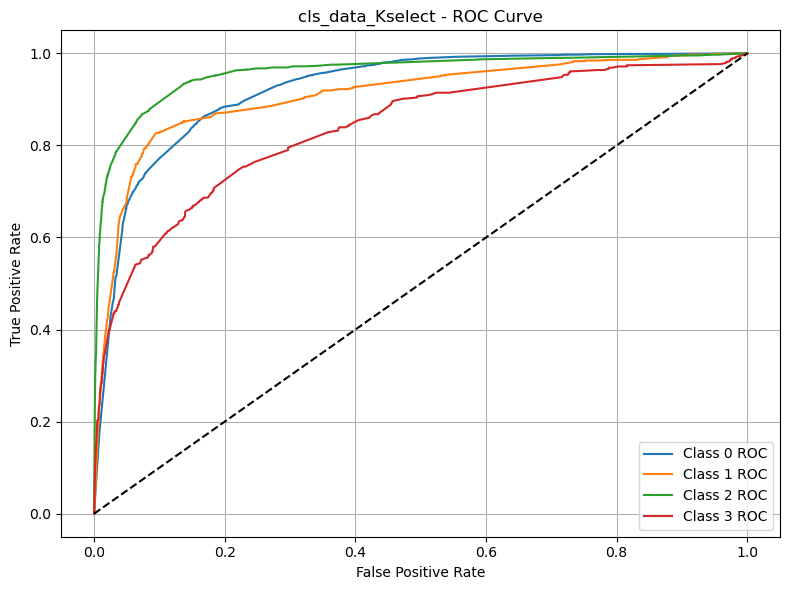

In [27]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_rf,
    X=X_selected_cls,
    y=y_selected_cls,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='cls_data_Kselect',
    n_jobs=-1
)

<font size=5>**K=50最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_50 (5折)=====

[Fold 1] ACC=0.8778, F1=0.6631, AUC=0.9350
[Fold 2] ACC=0.8727, F1=0.6440, AUC=0.9279
[Fold 3] ACC=0.8907, F1=0.6655, AUC=0.9359
[Fold 4] ACC=0.8843, F1=0.6574, AUC=0.9306
[Fold 5] ACC=0.8893, F1=0.7050, AUC=0.9441

=== 平均指标 (cls_data_Kselect_50) ===
accuracy: 0.8830
precision_macro: 0.8044
recall_macro: 0.6210
f1_macro: 0.6670
precision_weighted: 0.8752
recall_weighted: 0.8830
f1_weighted: 0.8709
auc: 0.9347

=== 最佳模型参数 ===
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
对应指标: {'accuracy': 0.8907221623414311, 'f1_macro': 0.6655212555877954, 'auc': np.float64(0.9359083966855426)}


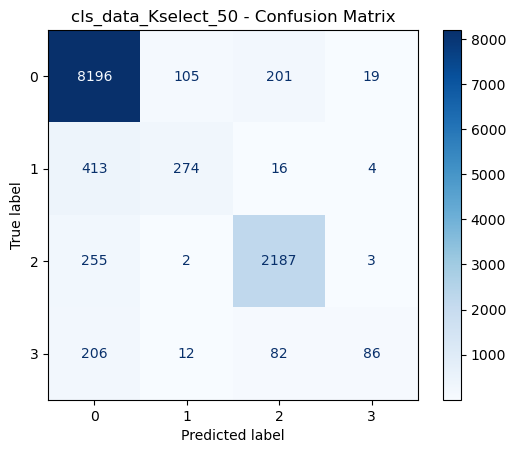

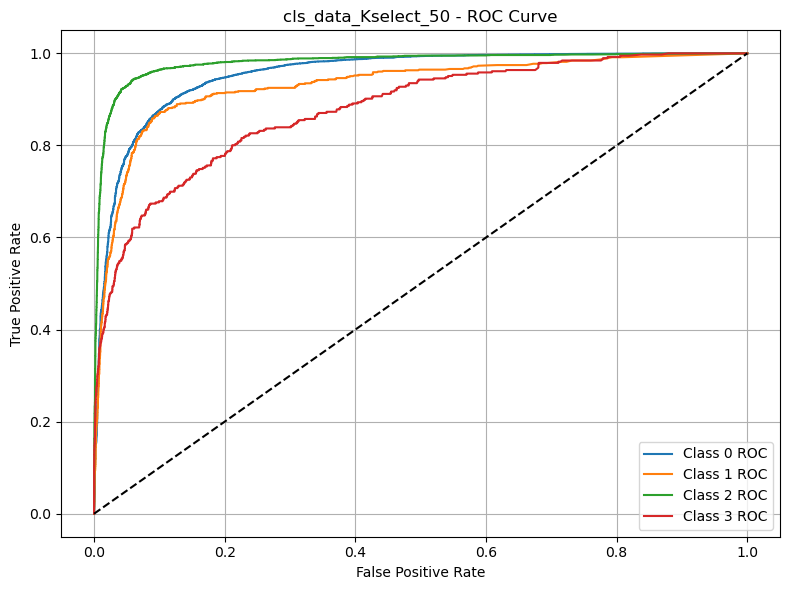

In [15]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_rf,
    X=X_selected_cls_50,
    y=y_selected_cls_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='cls_data_Kselect_50',
    n_jobs=-1
)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_cleaned (5折)=====



d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 1] ACC=0.8846, F1=0.4375, AUC=0.8771
[Fold 2] ACC=0.8685, F1=0.4245, AUC=0.8428


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 3] ACC=0.8891, F1=0.4325, AUC=0.8773


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 4] ACC=0.8839, F1=0.4266, AUC=0.8617
[Fold 5] ACC=0.8880, F1=0.4281, AUC=0.8872

=== 平均指标 (cls_data_Kselect_cleaned) ===
accuracy: 0.8828
precision_macro: 0.4643
recall_macro: 0.4218
f1_macro: 0.4298
precision_weighted: 0.8440
recall_weighted: 0.8828
f1_weighted: 0.8582
auc: 0.8692

=== 最佳模型参数 ===
{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
对应指标: {'accuracy': 0.8890889830508475, 'f1_macro': 0.4325050312652943, 'auc': np.float64(0.8773179128075884)}


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


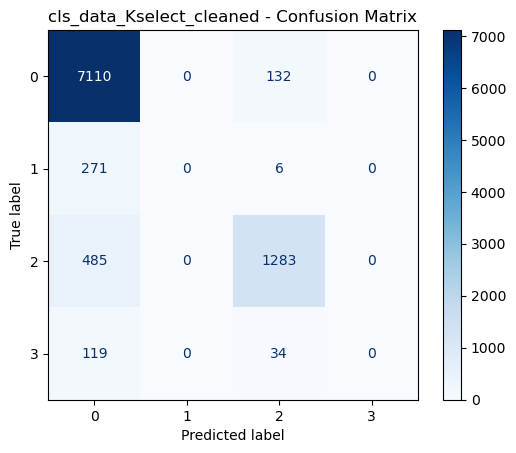

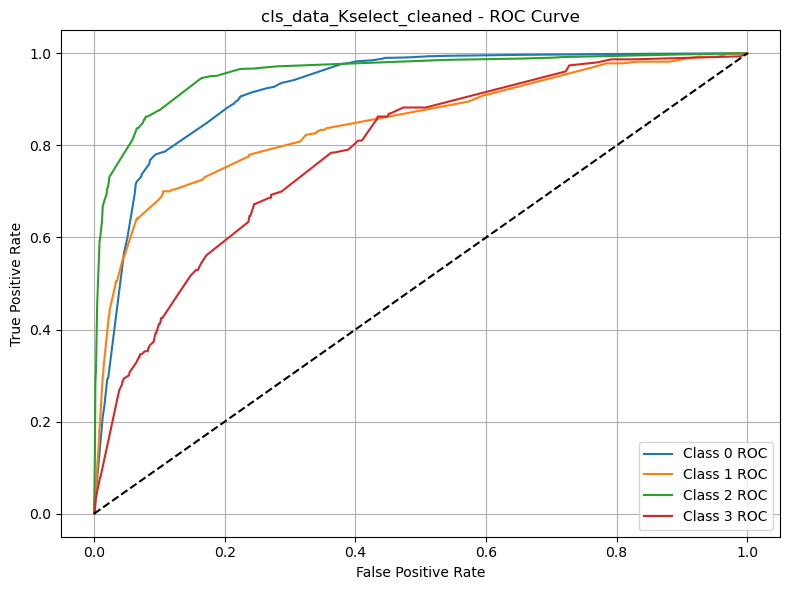

In [14]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_rf,
    X=X_selected_cls_cleaned,
    y=y_selected_cls_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='cls_data_Kselect_cleaned',
    n_jobs=-1
)

<font size=6>**SVM训练结果**</font>

<font size=5>**原始数据**</font>

<font size=5>**标准化数据**</font>

<font size=5>**K=10最优选择数据**</font>


===== 开始分类滚动评估：cls_data_Kselect (5折)=====

[Fold 1] ACC=0.8537, F1=0.6253, AUC=0.8446
[Fold 2] ACC=0.8355, F1=0.6122, AUC=0.8028
[Fold 3] ACC=0.8582, F1=0.6370, AUC=0.8482
[Fold 4] ACC=0.8535, F1=0.6272, AUC=0.8467
[Fold 5] ACC=0.8530, F1=0.6473, AUC=0.8634

=== 平均指标 (cls_data_Kselect) ===
accuracy: 0.8508
precision_macro: 0.7249
recall_macro: 0.5837
f1_macro: 0.6298
precision_weighted: 0.8400
recall_weighted: 0.8508
f1_weighted: 0.8389
auc: 0.8411

=== 最佳模型参数 ===
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
对应指标: {'accuracy': 0.8582207113837991, 'f1_macro': 0.6370445597832606, 'auc': np.float64(0.8482201189501437)}


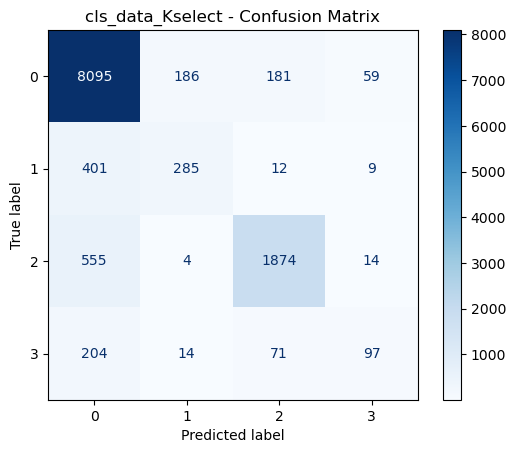

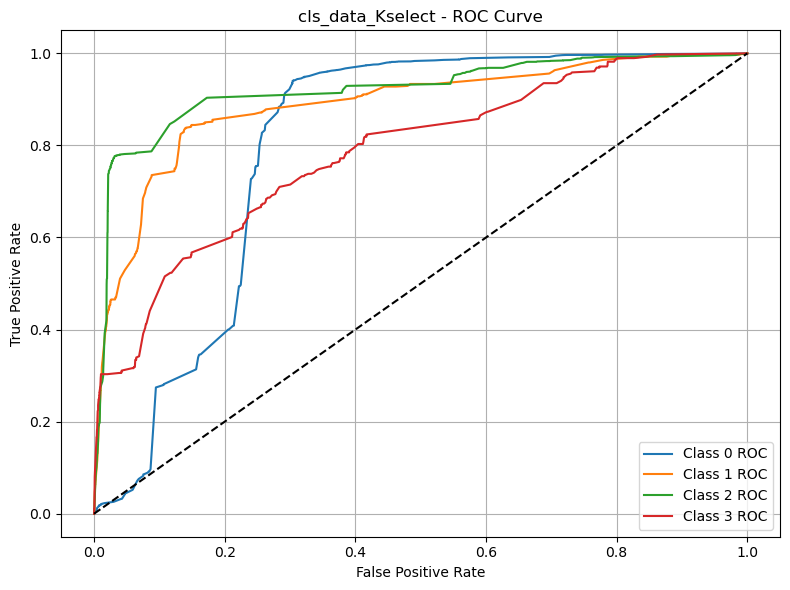

In [28]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_svm,
    X=X_selected_cls,
    y=y_selected_cls,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svm,
    data_name='cls_data_Kselect',
    n_jobs=-1
)

<font size=5>**K=50最优选择数据**</font>

In [ ]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_svm,
    X=X_selected_cls_50,
    y=y_selected_cls_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svm,
    data_name='cls_data_Kselect_50',
    n_jobs=6
)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始分类滚动评估：cls_data_Kselect_cleaned (5折)=====



d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 1] ACC=0.8847, F1=0.4379, AUC=0.7860


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 2] ACC=0.8674, F1=0.4114, AUC=0.7369


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 3] ACC=0.8892, F1=0.4415, AUC=0.7822


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Fold 4] ACC=0.8835, F1=0.4380, AUC=0.7845
[Fold 5] ACC=0.8870, F1=0.4272, AUC=0.7549

=== 平均指标 (cls_data_Kselect_cleaned) ===
accuracy: 0.8824
precision_macro: 0.4794
recall_macro: 0.4230
f1_macro: 0.4312
precision_weighted: 0.8452
recall_weighted: 0.8824
f1_weighted: 0.8580
auc: 0.7689

=== 最佳模型参数 ===
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
对应指标: {'accuracy': 0.8891949152542373, 'f1_macro': 0.44145024966445, 'auc': np.float64(0.7822461433360363)}


d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


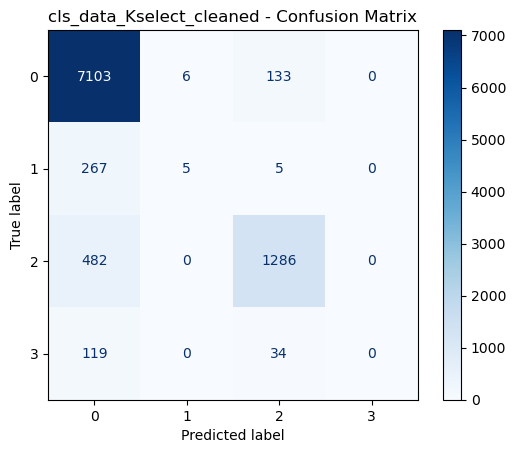

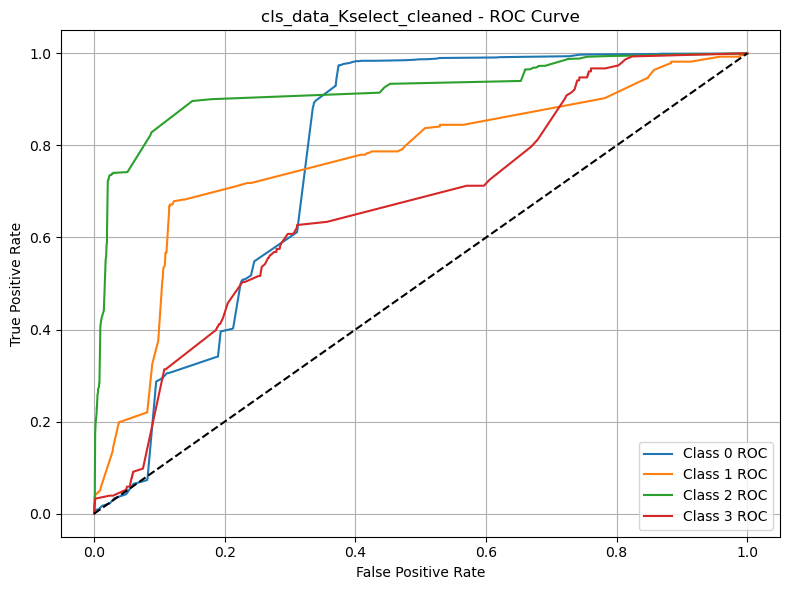

In [10]:
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_svm,
    X=X_selected_cls_cleaned,
    y=y_selected_cls_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svm,
    data_name='cls_data_Kselect_cleaned',
    n_jobs=-1
)

<font size=5>**LDA数据**</font>

<font size=6>**以下别动！**</font>

In [ ]:

best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_classification(
    model=model_svm,
    X=X_cls_lda,
    y=y_cls_lda,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svm,
    data_name='lda_data',
    n_jobs=-1
)